# Feature Selection, Engineering, Statistical Analysis & Outlier Handling

In this notebook, I am focusing on four main steps:

1. **Feature Selection**  
   - Deciding which features to keep based on domain relevance and what information is realistically available at (or near) release.  

2. **Feature Engineering**  
   - Creating derived variables such as release timing (year, month, quarter, weekday, season flags), `is_series`, and publisher game counts.  

3. **Statistical Analysis**  
   - Testing relationships between features and the target (`days_to_first_sale`) using:
     - **Correlation heatmap** for numerical features
     - Welch’s **t-tests** for binary features (with Cohen’s *d* for effect size).  
     - One-way **ANOVA** for multi-class features (with η² for effect size).  
   - Summarizing results to guide feature inclusion/exclusion.  

4. **Outlier Detection & Handling**  
   - Identifying and addressing outliers in key numerical features.  
   - Clipping extreme values for `launch_price` and `achievements`.  
   - Keeping `publisher_game_count` raw due to its business relevance and suitability for tree-based models.  

**Scope / boundaries**  
- This notebook ends with a clean, statistically validated, and outlier-adjusted feature set.  
- **Encoding, modeling, and evaluation** will be done in a separate notebook.  

**Deliverable from this notebook**  
- A well-documented, curated dataset that captures both engineered and original features, ready for encoding and model training in the next stage.

In [148]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from scipy.stats import ttest_ind, f_oneway

import sqlite3, pandas as pd
from contextlib import closing

DB_PATH = "/Users/farazahmed/Documents/GitHub/steam-discount-forecast/data/steam_sales.db"

In [149]:
with closing(sqlite3.connect(DB_PATH)) as conn:
    df = pd.read_sql("""
        WITH scoped_games AS (
            SELECT g.itad_id, g.appid, g.title, g.release_date,
                   g.early_access, g.mature
            FROM games g
            WHERE g.type='game'
              AND g.release_date BETWEEN '2021-01-01' AND '2024-12-31'
        ),
        tags_agg AS (
            SELECT gt.itad_id, GROUP_CONCAT(t.name, '; ') AS tags
            FROM game_tags gt JOIN tags t ON t.tag_id=gt.tag_id
            GROUP BY gt.itad_id
        ),
        first_hist_after_release AS (
            SELECT h.itad_id, MIN(h.ts_utc) AS first_ts
            FROM history_events h
            JOIN scoped_games sg ON sg.itad_id=h.itad_id
            WHERE date(h.ts_utc) >= date(sg.release_date)
            GROUP BY h.itad_id
        ),
        launch_price AS (
            SELECT fhar.itad_id, he.regular AS launch_price
            FROM first_hist_after_release fhar
            JOIN history_events he
              ON he.itad_id=fhar.itad_id AND he.ts_utc=fhar.first_ts
        ),
        first_sale_pick AS (
            SELECT h.itad_id, MIN(h.ts_utc) AS first_sale_ts
            FROM history_events h
            JOIN scoped_games sg ON sg.itad_id=h.itad_id
            WHERE date(h.ts_utc) > date(sg.release_date)
              AND h.price < h.regular    -- any discount, no 5% cutoff
            GROUP BY h.itad_id
        ),
        first_sale_enriched AS (
            SELECT fsp.itad_id,
                   fsp.first_sale_ts,
                   date(fsp.first_sale_ts) AS first_sale_date,
                   he.cut    AS first_sale_cut,
                   he.price  AS first_sale_price,
                   he.regular AS first_sale_regular
            FROM first_sale_pick fsp
            JOIN history_events he
              ON he.itad_id=fsp.itad_id AND he.ts_utc=fsp.first_sale_ts
        ),
        first_sale_labeled AS (
            SELECT fse.*,
                   CAST(ROUND(julianday(date(fse.first_sale_ts)) - julianday(g.release_date)) AS INTEGER)
                     AS days_to_first_sale
            FROM first_sale_enriched fse
            JOIN scoped_games g ON g.itad_id=fse.itad_id
        )
        SELECT
            sg.itad_id, sg.appid, sg.title, sg.release_date,
            sg.early_access, sg.mature,
            lp.launch_price,
            fsl.first_sale_date, fsl.first_sale_cut,
            fsl.first_sale_price, fsl.first_sale_regular,
            fsl.days_to_first_sale,
            ta.tags
        FROM scoped_games sg
        LEFT JOIN launch_price lp     ON lp.itad_id = sg.itad_id
        LEFT JOIN first_sale_labeled fsl ON fsl.itad_id = sg.itad_id
        LEFT JOIN tags_agg ta        ON ta.itad_id = sg.itad_id
        WHERE fsl.days_to_first_sale IS NOT NULL;
    """, conn)

df.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,first_sale_date,first_sale_cut,first_sale_price,first_sale_regular,days_to_first_sale,tags
0,018d937e-e9b7-73a9-84e1-1546a85c9841,NaN,Hacker,2024-03-29,0,0,0.99,2024-05-13,51,0.49,0.99,45,None
1,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,2023-12-21,20,10.39,12.99,54,RPG; Indie; Nudity; Sexual Content; Female Pro...
2,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,2021-11-24,20,19.99,24.99,50,Simulation; Sandbox; Management; Building; Res...
3,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,2023-11-10,20,7.99,9.99,35,Hand-drawn; Casual; Platformer; 2D Platformer;...
4,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,2022-12-22,40,5.39,8.99,66,Adventure; Simulation; Choices Matter; Sci-fi;...


In [150]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31246 entries, 0 to 31245
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31246 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31246 non-null  object 
 3   release_date        31246 non-null  object 
 4   early_access        31246 non-null  int64  
 5   mature              31246 non-null  int64  
 6   launch_price        31246 non-null  float64
 7   first_sale_date     31246 non-null  object 
 8   first_sale_cut      31246 non-null  int64  
 9   first_sale_price    31246 non-null  float64
 10  first_sale_regular  31246 non-null  float64
 11  days_to_first_sale  31246 non-null  int64  
 12  tags                31118 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 3.1+ MB


In [151]:
df.isna().sum()

itad_id                 0
appid                 128
title                   0
release_date            0
early_access            0
mature                  0
launch_price            0
first_sale_date         0
first_sale_cut          0
first_sale_price        0
first_sale_regular      0
days_to_first_sale      0
tags                  128
dtype: int64

In [152]:
# dropping the rowas with missing appid

df = df[~df['appid'].isna()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31118 entries, 1 to 31245
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31118 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31118 non-null  object 
 3   release_date        31118 non-null  object 
 4   early_access        31118 non-null  int64  
 5   mature              31118 non-null  int64  
 6   launch_price        31118 non-null  float64
 7   first_sale_date     31118 non-null  object 
 8   first_sale_cut      31118 non-null  int64  
 9   first_sale_price    31118 non-null  float64
 10  first_sale_regular  31118 non-null  float64
 11  days_to_first_sale  31118 non-null  int64  
 12  tags                31118 non-null  object 
dtypes: float64(4), int64(4), object(5)
memory usage: 3.3+ MB


#### The dataset from Kaggle contains some other useful features like "Age", "Achievements", "Categories", etc. I will join these features into my data.

In [153]:
df2 = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv")
df2.head()

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/2777268084.py:1: DtypeWarning: Columns (3,36) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/Kaggle datasets/93182_steam_games.csv")


,AppID,Name,Release date,Estimated owners,Peak CCU,Required age,Price,DLC count,About the game,Supported languages,...,Average playtime two weeks,Median playtime forever,Median playtime two weeks,Developers,Publishers,Categories,Genres,Tags,Screenshots,Movies
0,1424640,余烬,"Oct 3, 2020",20000 - 50000,0,0,3.99,0,'Ashes of war' is an anti war theme adventure ...,['Simplified Chinese'],...,0,0,0,宁夏华夏西部影视城有限公司,宁夏华夏西部影视城有限公司,"Single-player,Family Sharing","Adventure,Casual,Indie,RPG","Sokoban,RPG,Puzzle-Platformer,Exploration,Adve...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
1,402890,Nyctophilia,"Sep 23, 2015",50000 - 100000,0,0,0.00,0,NYCTOPHILIA Nyctophilia is an 2D psychological...,"['English', 'Russian']",...,0,0,0,Cat In A Jar Games,Cat In A Jar Games,Single-player,"Adventure,Free To Play,Indie","Free to Play,Indie,Adventure,Horror,2D,Pixel G...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
2,1151740,Prison Princess,"Apr 2, 2020",0 - 20000,0,0,19.99,0,"ABOUT Now nothing more than a phantom, can the...","['English', 'Simplified Chinese', 'Traditional...",...,0,0,0,qureate,qureate,"Single-player,Steam Achievements,Full controll...","Adventure,Indie","Sexual Content,Adventure,Indie,Nudity,Anime,Ma...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
3,875530,Dead In Time,"Oct 12, 2018",0 - 20000,0,0,7.99,0,Is a hardcore action with a non-trivial level ...,"['English', 'Russian']",...,0,0,0,Zelenov Artem,Zelenov Artem,"Single-player,Full controller support,Family S...","Action,Indie","Action,Indie,Souls-like,Fantasy,Early Access,R...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...
4,1835360,Panacle: Back To Wild,"Mar 11, 2022",0 - 20000,2,0,3.99,0,Panacle: Back to the Wild is a indie card game...,"['English', 'Japanese', 'Simplified Chinese', ...",...,0,0,0,渡鸦游戏,"渡鸦游戏,电钮组","Single-player,Family Sharing","Indie,Strategy,Early Access","Trading Card Game,Turn-Based Strategy,Lore-Ric...",https://shared.akamai.steamstatic.com/store_it...,http://video.akamai.steamstatic.com/store_trai...


In [154]:
# renaming "AppID" column to "appid" to match with df

df2.rename(columns={"AppID": "appid"}, inplace=True)

In [155]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93182 entries, 0 to 93181
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   appid                       93182 non-null  int64  
 1   Name                        93179 non-null  object 
 2   Release date                93182 non-null  object 
 3   Estimated owners            16462 non-null  object 
 4   Peak CCU                    93182 non-null  int64  
 5   Required age                93182 non-null  int64  
 6   Price                       93182 non-null  float64
 7   DLC count                   93182 non-null  int64  
 8   About the game              88392 non-null  object 
 9   Supported languages         93182 non-null  object 
 10  Full audio languages        93182 non-null  object 
 11  Reviews                     10599 non-null  object 
 12  Header image                93182 non-null  object 
 13  Website                     416

In [156]:
# merging the two dataframes on "appid" and keeping the columns "Required Age", "Windoes", "Mac", "Linux", "Achievements", "Developer", "Publisher", "Categories", "Genres"

df_merged = pd.merge(df, df2[['appid', 'Required age', 'Windows', 'Mac', 'Linux', 'Achievements', 'Developers', 'Publishers', 'Categories', 'Genres']], on='appid', how='left')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31118 entries, 0 to 31117
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             31118 non-null  object 
 1   appid               31118 non-null  float64
 2   title               31118 non-null  object 
 3   release_date        31118 non-null  object 
 4   early_access        31118 non-null  int64  
 5   mature              31118 non-null  int64  
 6   launch_price        31118 non-null  float64
 7   first_sale_date     31118 non-null  object 
 8   first_sale_cut      31118 non-null  int64  
 9   first_sale_price    31118 non-null  float64
 10  first_sale_regular  31118 non-null  float64
 11  days_to_first_sale  31118 non-null  int64  
 12  tags                31118 non-null  object 
 13  Required age        31115 non-null  float64
 14  Windows             31115 non-null  object 
 15  Mac                 31115 non-null  object 
 16  Linu

In [157]:
df_merged.isna().sum()

itad_id                 0
appid                   0
title                   0
release_date            0
early_access            0
mature                  0
launch_price            0
first_sale_date         0
first_sale_cut          0
first_sale_price        0
first_sale_regular      0
days_to_first_sale      0
tags                    0
Required age            3
Windows                 3
Mac                     3
Linux                   3
Achievements            3
Developers             32
Publishers            136
Categories              5
Genres                 34
dtype: int64

In [158]:
# dropping the rows with missing "Required age", "Windows", "Mac", "Linux", "Achievements", "Developer", "Publisher", "Categories", "Genres"
df_merged = df_merged[~df_merged['Required age'].isna()]
df_merged = df_merged[~df_merged['Windows'].isna()]
df_merged = df_merged[~df_merged['Mac'].isna()]
df_merged = df_merged[~df_merged['Linux'].isna()]
df_merged = df_merged[~df_merged['Achievements'].isna()]
df_merged = df_merged[~df_merged['Developers'].isna()]
df_merged = df_merged[~df_merged['Publishers'].isna()]
df_merged = df_merged[~df_merged['Categories'].isna()]
df_merged = df_merged[~df_merged['Genres'].isna()]
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   first_sale_date     30947 non-null  object 
 8   first_sale_cut      30947 non-null  int64  
 9   first_sale_price    30947 non-null  float64
 10  first_sale_regular  30947 non-null  float64
 11  days_to_first_sale  30947 non-null  int64  
 12  tags                30947 non-null  object 
 13  Required age        30947 non-null  float64
 14  Windows             30947 non-null  object 
 15  Mac                 30947 non-null  object 
 16  Linux    

In [159]:
# lets make quick check of duplicates based on appid
df_merged['appid'].duplicated().sum()

np.int64(0)

## Feature Selection: In this section I use qualitative and quantitative analysis to select features that are important and relevant for modelling 

#### From the users perspective it is not possible for them to have the data like: "first_sale_date", "first_sale_cut", "first_sale_price", "first_sale_regular". So it does not make sense to have them in the model.

In [160]:
# dropping "first_sale_date", "first_sale_price", "first_sale_regular", "first_sale_cut"

df_merged.drop(columns=['first_sale_date', 'first_sale_price', 'first_sale_regular', 'first_sale_cut'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   tags                30947 non-null  object 
 9   Required age        30947 non-null  float64
 10  Windows             30947 non-null  object 
 11  Mac                 30947 non-null  object 
 12  Linux               30947 non-null  object 
 13  Achievements        30947 non-null  float64
 14  Developers          30947 non-null  object 
 15  Publishers          30947 non-null  object 
 16  Categorie

#### Analysing tags, categories and genres

In [161]:
df_merged[['tags', 'Categories', 'Genres']].head(10)

,tags,Categories,Genres
0,RPG; Indie; Nudity; Sexual Content; Female Pro...,"Single-player,Steam Cloud,Family Sharing","Indie,RPG"
1,Simulation; Sandbox; Management; Building; Res...,"Single-player,Steam Workshop,Family Sharing","Casual,Indie,Simulation,Strategy,Early Access"
2,Hand-drawn; Casual; Platformer; 2D Platformer;...,"Single-player,Multi-player,Co-op,Online Co-op,...","Action,Adventure,Casual,Indie,Strategy"
3,Adventure; Simulation; Choices Matter; Sci-fi;...,"Single-player,Family Sharing","Adventure,Indie,RPG,Simulation,Strategy,Early ..."
4,Indie; Horror; Retro; Immersive Sim; Survival ...,"Single-player,Partial Controller Support,Famil...","Action,Adventure,Indie,Simulation"
5,Singleplayer; Story Rich; Visual Novel; Romanc...,"Single-player,Steam Achievements,Family Sharing","Adventure,Indie,Simulation"
6,2D; Casual; Card Game; Football (Soccer); Soli...,"Single-player,Family Sharing",Casual
7,Base Building; Strategy; Deckbuilding; Funny; ...,"Single-player,Steam Achievements,Steam Cloud,F...","Indie,Strategy"
8,Adventure; RPG; Indie; Cute; Great Soundtrack,"Single-player,Multi-player,Co-op,Shared/Split ...","Adventure,Indie,RPG"
9,Wargame; Real Time Tactics; Military; Hero Sho...,"Single-player,Family Sharing","Action,Casual,Simulation,Strategy"


#### There are 400 plus unique tags present in the data. Having them in the model would require me to one-hot encode them which would explode the dimensionality and will not feasible for model training. I also think that it does not make sense to have tags that many or that granualar, also it is redundant with "Categories" and "Genres" present. For these reasons I will be dropping the tags columnm. 

In [162]:
# dropping "tags" column as it is redundant with "Categories" and "Genres"

df_merged.drop(columns=['tags'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  object 
 10  Mac                 30947 non-null  object 
 11  Linux               30947 non-null  object 
 12  Achievements        30947 non-null  float64
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genres   

#### Lets now analyse the "Categories" and "Genres" separately and see what information do they carry.

Unique categories: 38
Unique genres: 20
Top 10 categories cover: 85.7% of games
Top 10 genres cover:     99.3% of games


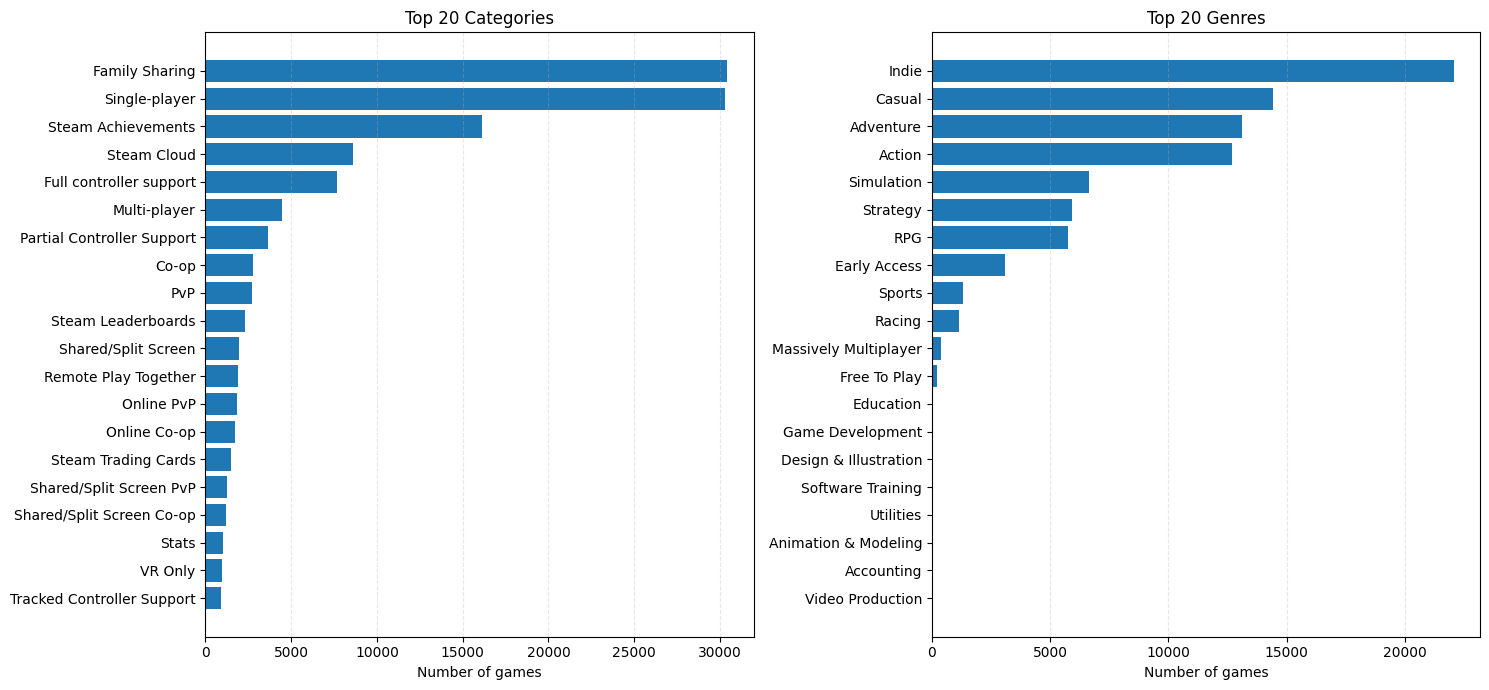

In [163]:
# helper to split comma/semicolon lists safely
def split_multi(x):
    if pd.isna(x): 
        return []
    parts = re.split(r"[;,]", str(x))
    return [p.strip() for p in parts if p.strip()]

# explode to one row per token
cats = df_merged["Categories"].apply(split_multi).explode()
gens = df_merged["Genres"].apply(split_multi).explode()

# counts
cat_counts = cats.value_counts()
gen_counts = gens.value_counts()

print("Unique categories:", cat_counts.shape[0])
print("Unique genres:", gen_counts.shape[0])

# quick coverage info (optional)
def coverage(series, k=10):
    return 100 * series.head(k).sum() / series.sum()
print(f"Top 10 categories cover: {coverage(cat_counts,10):.1f}% of games")
print(f"Top 10 genres cover:     {coverage(gen_counts,10):.1f}% of games")

# plot top-N bar charts
TOPN = 20
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# categories
cc = cat_counts.head(TOPN)[::-1]  # reverse for horizontal bars
axes[0].barh(cc.index, cc.values)
axes[0].set_title(f"Top {TOPN} Categories")
axes[0].set_xlabel("Number of games")
axes[0].grid(axis="x", linestyle="--", alpha=0.3)

# genres
gg = gen_counts.head(TOPN)[::-1]
axes[1].barh(gg.index, gg.values)
axes[1].set_title(f"Top {TOPN} Genres")
axes[1].set_xlabel("Number of games")
axes[1].grid(axis="x", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

### Feature Selection: Categories, Genres, and Tags

In my analysis of the dataset, I noticed that **Categories** and **Genres** provide structured and interpretable information, while **Tags** are extremely granular with over 400 unique values.

- For **Categories**, I am deciding to keep only the three most important ones:  
  **Single-player, Multiplayer, and Family Sharing.**  
  These are the dominant categories across games, intuitive for users to understand, and easy to encode for the model. Dropping niche categories avoids unnecessary noise.

- For **Genres**, I am keeping the **top 11 genres up to Massively Multiplayer.**  
  These cover the vast majority of games, represent meaningful distinctions (e.g., RPG vs Strategy), and provide strong predictive value without overwhelming the model.

- For **Tags**, I chose to drop them entirely.  
  With 400+ unique tags, one-hot encoding would be impractical and would clutter both the model and the user interface. Tags are also inconsistent and too fine-grained to be useful at this stage.

In [164]:
# keeping only the categories: "Family Sharing", "Single-player", "Multi-player" rest as "Other"
# for genres keeping the top 11 genres rest as "Other"

top_categories = ["Family Sharing", "Single-player", "Multi-player"]
top_genres = gen_counts.head(11).index.tolist() # getting top 11 genres

def simplify_categories(x):
    cats = split_multi(x)
    simplified = [c if c in top_categories else "Other" for c in cats]
    return "; ".join(sorted(set(simplified)))  # unique and sorted

def simplify_genres(x):
    gens = split_multi(x)
    simplified = [g if g in top_genres else "Other" for g in gens]
    return "; ".join(sorted(set(simplified)))  # unique and sorted

df_merged['Categories'] = df_merged['Categories'].apply(simplify_categories)
df_merged['Genres'] = df_merged['Genres'].apply(simplify_genres)
df_merged[['Categories', 'Genres']].head(10)

,Categories,Genres
0,Family Sharing; Other; Single-player,Indie; RPG
1,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy
2,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy
3,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...
4,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation
5,Family Sharing; Other; Single-player,Adventure; Indie; Simulation
6,Family Sharing; Single-player,Casual
7,Family Sharing; Other; Single-player,Indie; Strategy
8,Family Sharing; Multi-player; Other; Single-pl...,Adventure; Indie; RPG
9,Family Sharing; Single-player,Action; Casual; Simulation; Strategy


### Here a I am making and saving a dataset with additional columns for review scores. This data can be used to make sales predictions after the release date when the early reviews of the games come in.

In [165]:
q_review = """
WITH pivot AS (
  SELECT
    g.itad_id,
    g.appid,

    -- Steam
    MAX(CASE WHEN r.source='Steam' THEN r.score END) AS steam_score,
    MAX(CASE WHEN r.source='Steam' THEN r.count END) AS steam_count,

    -- OpenCritic
    MAX(CASE WHEN r.source='OpenCritic' THEN r.score END) AS opencritic_score,
    MAX(CASE WHEN r.source='OpenCritic' THEN r.count END) AS opencritic_count,

    -- Metascore (critics)
    MAX(CASE WHEN r.source='Metascore' THEN r.score END) AS metascore_score,
    MAX(CASE WHEN r.source='Metascore' THEN r.count END) AS metascore_count,

    -- Metacritic User Score
    MAX(CASE WHEN r.source='Metacritic User Score' THEN r.score END) AS mc_user_score,
    MAX(CASE WHEN r.source='Metacritic User Score' THEN r.count END) AS mc_user_count

  FROM games g
  LEFT JOIN reviews r ON r.itad_id = g.itad_id
  GROUP BY g.itad_id, g.appid
),
final AS (
  SELECT
    *,
    -- master score/count + which source was chosen
    CASE
      WHEN steam_score        IS NOT NULL THEN steam_score
      WHEN opencritic_score   IS NOT NULL THEN opencritic_score
      WHEN metascore_score    IS NOT NULL THEN metascore_score
      WHEN mc_user_score      IS NOT NULL THEN mc_user_score
      ELSE NULL
    END AS review_score,

    CASE
      WHEN steam_score        IS NOT NULL THEN steam_count
      WHEN opencritic_score   IS NOT NULL THEN opencritic_count
      WHEN metascore_score    IS NOT NULL THEN metascore_count
      WHEN mc_user_score      IS NOT NULL THEN mc_user_count
      ELSE NULL
    END AS review_count,

    CASE
      WHEN steam_score        IS NOT NULL THEN 'Steam'
      WHEN opencritic_score   IS NOT NULL THEN 'OpenCritic'
      WHEN metascore_score    IS NOT NULL THEN 'Metascore'
      WHEN mc_user_score      IS NOT NULL THEN 'Metacritic User Score'
      ELSE NULL
    END AS review_source
  FROM pivot
)
SELECT * FROM final;
"""

with closing(sqlite3.connect(DB_PATH)) as conn:
    df_reviews = pd.read_sql(q_review, conn)

df_reviews.head()

,itad_id,appid,steam_score,steam_count,opencritic_score,opencritic_count,metascore_score,metascore_count,mc_user_score,mc_user_count,review_score,review_count,review_source
0,018d937e-e9b5-71d6-a320-3543fb1ce11f,2080950.0,62.0,29.0,NaN,NaN,NaN,NaN,NaN,1.0,62.0,29.0,Steam
1,018d937e-e9b7-73a9-84e1-1546a85c9841,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
2,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,77.0,109.0,NaN,NaN,NaN,NaN,NaN,NaN,77.0,109.0,Steam
3,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,61.0,389.0,NaN,NaN,NaN,NaN,NaN,1.0,61.0,389.0,Steam
4,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,96.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN,96.0,56.0,Steam


In [166]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   itad_id           43140 non-null  object 
 1   appid             42872 non-null  float64
 2   steam_score       39323 non-null  float64
 3   steam_count       39323 non-null  float64
 4   opencritic_score  1976 non-null   float64
 5   opencritic_count  4259 non-null   float64
 6   metascore_score   1487 non-null   float64
 7   metascore_count   3342 non-null   float64
 8   mc_user_score     2560 non-null   float64
 9   mc_user_count     6832 non-null   float64
 10  review_score      39346 non-null  float64
 11  review_count      39346 non-null  float64
 12  review_source     39346 non-null  object 
dtypes: float64(11), object(2)
memory usage: 4.3+ MB


In [167]:
df_reviews = df_reviews[['itad_id', 'appid', 'review_score', 'review_count', 'review_source']]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43140 entries, 0 to 43139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   itad_id        43140 non-null  object 
 1   appid          42872 non-null  float64
 2   review_score   39346 non-null  float64
 3   review_count   39346 non-null  float64
 4   review_source  39346 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.6+ MB


In [168]:
df_reviews.isna().sum()

itad_id             0
appid             268
review_score     3794
review_count     3794
review_source    3794
dtype: int64

In [169]:
# letting only the rows with non-null review_score and appid

df_reviews = df_reviews[~df_reviews['review_score'].isna()]
df_reviews = df_reviews[~df_reviews['appid'].isna()]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 39337 entries, 0 to 43139
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   itad_id        39337 non-null  object 
 1   appid          39337 non-null  float64
 2   review_score   39337 non-null  float64
 3   review_count   39337 non-null  float64
 4   review_source  39337 non-null  object 
dtypes: float64(3), object(2)
memory usage: 1.8+ MB


In [170]:
# merging df_merged with df_reviews on "appid" and "itad_id" and keeping only one itad_id column

df_v2 = pd.merge(df_merged, df_reviews, on=['appid', 'itad_id'], how='left')
df_v2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  object 
 10  Mac                 30947 non-null  object 
 11  Linux               30947 non-null  object 
 12  Achievements        30947 non-null  float64
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genr

In [171]:
# saving to csv

df_v2.to_csv("steam_games_enriched.csv", index=False)
df_v2.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Required age,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres,review_score,review_count,review_source
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,0.0,True,False,False,0.0,Lovely Pretty Ultra Loving You,Kagura Games,Family Sharing; Other; Single-player,Indie; RPG,77.0,109.0,Steam
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,0.0,True,True,True,0.0,Arcade Oven,Arcade Oven,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy,61.0,389.0,Steam
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,0.0,True,False,False,19.0,"Tripp Rainey,Brice DiPiazza",Trippster Studios,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy,96.0,56.0,Steam
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,0.0,True,False,False,39.0,2Dogs Games Ltd.,Bonus Stage Publishing,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...,56.0,23.0,Steam
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,0.0,True,True,False,29.0,Puppet Combo,Puppet Combo,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation,94.0,1350.0,Steam


### Lets go back to working with our pre-release version of the dataset.

In [172]:
df_merged.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Required age,Windows,Mac,Linux,Achievements,Developers,Publishers,Categories,Genres
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,0.0,True,False,False,0.0,Lovely Pretty Ultra Loving You,Kagura Games,Family Sharing; Other; Single-player,Indie; RPG
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,0.0,True,True,True,0.0,Arcade Oven,Arcade Oven,Family Sharing; Other; Single-player,Casual; Early Access; Indie; Simulation; Strategy
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,0.0,True,False,False,19.0,"Tripp Rainey,Brice DiPiazza",Trippster Studios,Family Sharing; Multi-player; Other; Single-pl...,Action; Adventure; Casual; Indie; Strategy
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,0.0,True,False,False,39.0,2Dogs Games Ltd.,Bonus Stage Publishing,Family Sharing; Single-player,Adventure; Early Access; Indie; RPG; Simulatio...
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,0.0,True,True,False,29.0,Puppet Combo,Puppet Combo,Family Sharing; Other; Single-player,Action; Adventure; Indie; Simulation


In [173]:
# converting "Windoes", "Mac", "Linux", "Achievements", "early_access", "mature" to integer

df_merged['Windows'] = df_merged['Windows'].astype(int)
df_merged['Mac'] = df_merged['Mac'].astype(int)
df_merged['Linux'] = df_merged['Linux'].astype(int)
df_merged['Achievements'] = df_merged['Achievements'].astype(int)
df_merged['early_access'] = df_merged['early_access'].astype(int)
df_merged['mature'] = df_merged['mature'].astype(int)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   itad_id             30947 non-null  object 
 1   appid               30947 non-null  float64
 2   title               30947 non-null  object 
 3   release_date        30947 non-null  object 
 4   early_access        30947 non-null  int64  
 5   mature              30947 non-null  int64  
 6   launch_price        30947 non-null  float64
 7   days_to_first_sale  30947 non-null  int64  
 8   Required age        30947 non-null  float64
 9   Windows             30947 non-null  int64  
 10  Mac                 30947 non-null  int64  
 11  Linux               30947 non-null  int64  
 12  Achievements        30947 non-null  int64  
 13  Developers          30947 non-null  object 
 14  Publishers          30947 non-null  object 
 15  Categories          30947 non-null  object 
 16  Genres   

### Feature engineering

#### Lets extract temporal features from "release_date", here's what I am looking to extract and my reasoning behind it,

1. ##### year: This captures trends over time.
2. ##### month: For seasonal patterns there are big sales in November (Autumn Sale, Black Friday) and December (Winter Sale)
3. ##### day_of_month: Sometimes publishers align with marketing cycles (early vs. end-of-month)
4. ##### day_of_week: Friday releases are common for reaching bigger audience, higher initial sales, may affect timing of first discount.
5. ##### quarter: Q1, Q2, Q3, Q4. Q4 often coincides with holiday season discounts
6. ##### is_holiday_season(binary 1/0): 1 if November-December else 0
7. ##### is_summer_sale_window(binary 1/0): June/July often aligns with the big Steam Summer Sale
8. ##### time_since_steam_launch(since September 2003): Difference in days from Steam’s platform age (to capture shifts in store-wide discount strategies). 

In [174]:
# extracting temporal features from "release_date"

df_merged['release_date'] = pd.to_datetime(df_merged['release_date'], errors='coerce')

df_merged['release_year'] = df_merged['release_date'].dt.year
df_merged['release_month'] = df_merged['release_date'].dt.month
df_merged['release_day'] = df_merged['release_date'].dt.day
df_merged['release_quarter'] = df_merged['release_date'].dt.quarter
df_merged['release_weekday'] = df_merged['release_date'].dt.weekday

# is_holiday_season(binary 1/0): 1 if November-December else 0
df_merged['is_holiday_season'] = df_merged['release_month'].apply(lambda x: 1 if x in [11, 12] else 0)

# is_summer_sale_window(binary 1/0): June/July often aligns with the big Steam Summer Sale
df_merged['is_summer_sale_window'] = df_merged['release_month'].apply(lambda x: 1 if x in [6, 7] else 0)

# time_since_steam_launch(since September 2003): Difference in days from Steam’s platform age (to capture shifts in store-wide discount strategies)
steam_launch_date = pd.to_datetime('2003-09-12')
df_merged['time_since_steam_launch'] = (df_merged['release_date'] - steam_launch_date).dt.days

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

#### Series Indicator: I am adding a feture that classifies a game as a part of a series like for example, Assassin's Creed, Assassin's Creed 2, etc. This will capture the effect of market power and reputation effects.

### Series / Franchise Identification (`is_series`)

I flag a game as part of a series (`is_series = 1`) using robust title-based cues. The logic looks for **strong sequel patterns** and (by design) also includes **re-releases/editions** to capture franchise continuity.

**Strong sequel cues (examples):**
- Explicit numbering in the title: Arabic numerals **2–20** (e.g., *Game 2*, *Game 10*) or Roman numerals **II–XII** (e.g., *Game IV*).
- Structured sequel words with numbers: **Episode**, **Part**, **Chapter**, **Season** followed by a number/roman (e.g., *Game – Episode 3*, *Part II*).
- Collection/series terms: **Trilogy**, **Tetralogy/Quadrilogy**, **Saga**, **Anthology**.

**Re-release / edition cues (included by choice):**
- **Remaster/Remastered**, **Remake**, **Redux**, **HD Remaster**  
- **Definitive Edition**, **Enhanced Edition**, **Director’s Cut**, **Complete Edition**, **GOTY / Game of the Year**, **Anniversary**, **Ultra Deluxe**

**False-positive guards:**
- Avoid matching plain **years** (e.g., “2020”, “2024”) as sequels.
- Optionally exclude phrases like **“Season Pass”** from season-based matches.

**Why include re-releases?**  
They indicate an existing franchise/IP with established audience and pricing patterns, which often correlates with discount strategy. For this project, I use the **inclusive** flag that counts both sequels and re-releases as series.

**Notes & limitations:**
- This is a **title-pattern heuristic**; it won’t catch all franchises (e.g., subtitled sequels with no numbers) and may miss rare naming schemes.
- The patterns are configurable; I can refine them if noise appears during audit (e.g., add exclusions or extend roman numerals).

Result: a reproducible binary feature `is_series` (inclusive) that captures franchise/continuity signals likely relevant to discount timing.

In [175]:
# adding a column "is_series" binary 1/0 if the title contains "Episode", "Part", "Chapter", "Season", "Saga", "Trilogy", "Quadrology", "Remastered"

# --- build regexes (case-insensitive) ---

# 1) Strong sequel indicators
#   - Roman numerals: II, III, IV, V, VI, VII, VIII, IX, X, XI, XII
#   - Arabic numerals: 2–20 (bounded as separate words to avoid years like 2020)
#   - Words with explicit numbering: Episode/Part/Chapter/Season + number/roman
#   - Collection words: Trilogy, Tetralogy/Quadrilogy, Saga, Anthology
roman_nums   = r"(?:ii|iii|iv|v|vi|vii|viii|ix|x|xi|xii)"
arabic_nums  = r"(?:[2-9]|1[0-9]|20)"                 # 2..20
num_token    = rf"(?:{arabic_nums}|{roman_nums})"
word_number  = rf"(?:episode|part|chapter|season)\s*{num_token}\b"

strong_tokens = [
    rf"\b{num_token}\b",                               # "Game II", "Game 2"
    word_number,                                       # "Episode 3", "Part IV"
    r"\btrilogy\b",
    r"\btetralogy\b|\bquadrilogy\b|\bquadrology\b",    # common spellings
    r"\bsaga\b",
    r"\banthology\b",
]

STRONG_RE = re.compile("|".join(strong_tokens), re.IGNORECASE)

# 2) Soft re-release / edition indicators (not always a series, but often implies prior title)
soft_tokens = [
    r"\bremaster(?:ed)?\b",                            # Remaster, Remastered
    r"\bremake\b",
    r"\bredux\b",
    r"\bdefinitive\s+edition\b",
    r"\benhanced\s+edition\b",
    r"\bdirector'?s\s+cut\b",
    r"\bhd\s+remaster\b",
    r"\bgoty\b|\bgame\s+of\s+the\s+year\b",
    r"\bcomplete\s+edition\b|\bultra\s+deluxe\b|\banniversary\b",
]
SOFT_RE = re.compile("|".join(soft_tokens), re.IGNORECASE)

# --- helpers ---

def is_series_title(title: str, include_soft=False) -> int:
    """
    Return 1 if title looks like part of a series.
    include_soft=True will also count remasters/editions as series.
    """
    if not isinstance(title, str) or not title.strip():
        return 0
    t = title.strip()
    if STRONG_RE.search(t):
        return 1
    if include_soft and SOFT_RE.search(t):
        return 1
    return 0

def has_soft_rerelease(title: str) -> int:
    if not isinstance(title, str) or not title.strip():
        return 0
    return int(bool(SOFT_RE.search(title)))

# --- apply to your DataFrame (df_merged) ---

# Strict series only (recommended for modeling)
df_merged["is_series_strict"] = df_merged["title"].apply(is_series_title)

# If you want a single flag that also treats remasters/editions as series:
df_merged["is_series_inclusive"] = df_merged["title"].apply(lambda s: is_series_title(s, include_soft=True))

# Optional: keep a separate soft flag for analysis
df_merged["is_rerelease_soft"] = df_merged["title"].apply(has_soft_rerelease)

# Choose the one you want to use as your feature:
# df_merged["is_series"] = df_merged["is_series_strict"]        # conservative
# or
# df_merged["is_series"] = df_merged["is_series_inclusive"]     # broader

In [176]:
# keeping only the inclusive version

df_merged.drop(columns=['is_series_strict', 'is_rerelease_soft'], inplace=True)
df_merged.rename(columns={'is_series_inclusive': 'is_series'}, inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

#### I am adding a "publisher_game_count" to the dataset which contains the number of games published by a specific publisher. This gives an idea of how big or small a publisher is and would help in capturing trends for publisher behaviour in giving discount.

In [177]:
# adding a "publisher_game_count" column that counts how many games each publisher has in the dataset

publisher_counts = df_merged['Publishers'].value_counts().to_dict()
df_merged['publisher_game_count'] = df_merged['Publishers'].map(publisher_counts)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

### Statistical Analysis

In [178]:
# creating final lists of numerical and categorical columns

num_cols = ['launch_price', 'Achievements', 'publisher_game_count', 'time_since_steam_launch']

cat_cols = ['Windows', 'Mac', 'Linux', 'early_access', 'Required age', 'mature', 'Developers', 'Publishers', 'release_year', 'release_month', 'release_quarter', 'release_weekday', 'is_holiday_season', 'is_summer_sale_window', 'is_series']

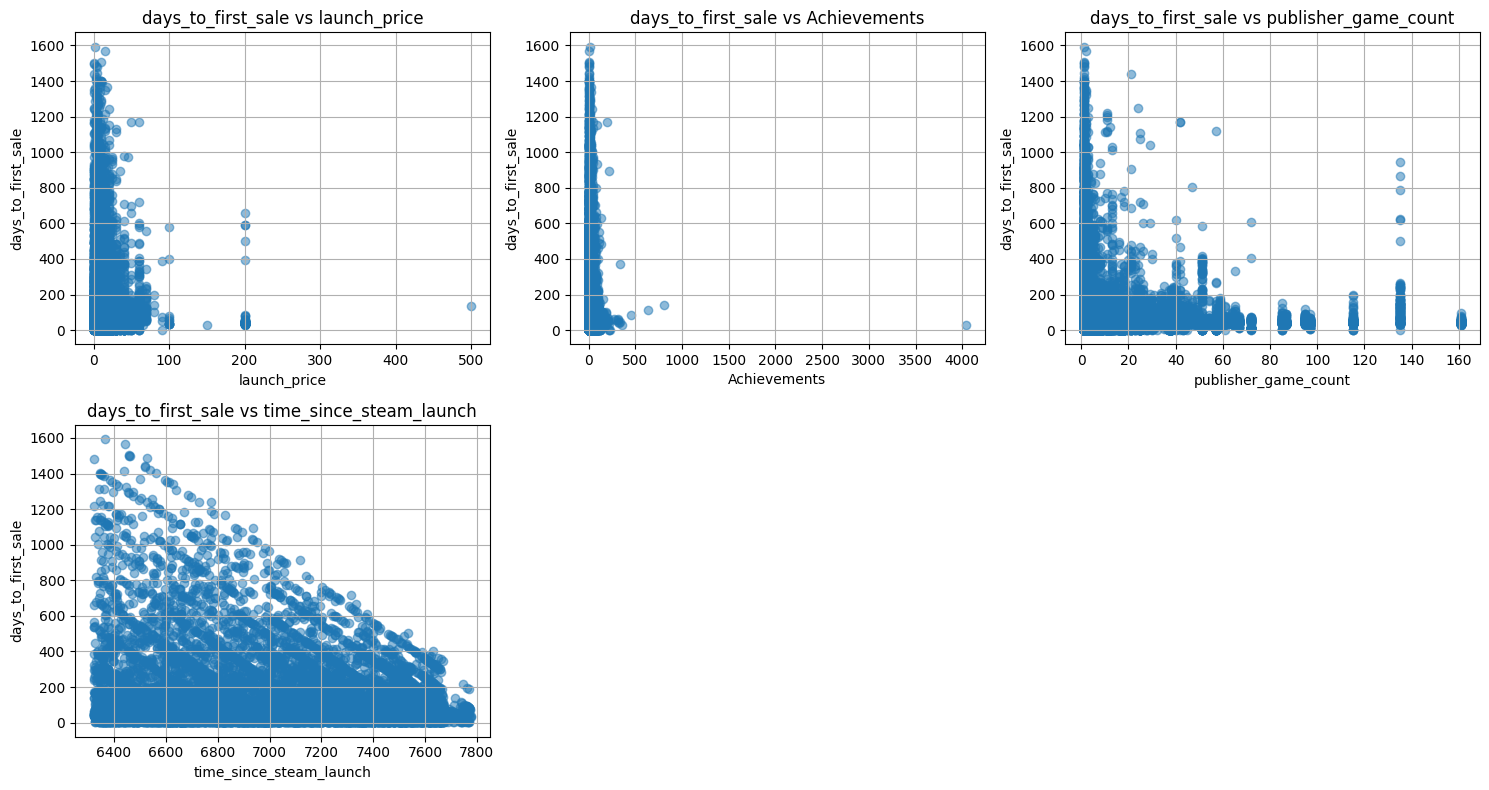

In [179]:
# scatter plots of all numerical features vs days_to_first_sale

num_plots = len(num_cols)
n_cols = 3
n_rows = (num_plots + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5*n_cols, 4*n_rows))
axes = axes.flatten()
for i, col in enumerate(num_cols):
    if col not in df_merged.columns:
        continue
    axes[i].scatter(df_merged[col], df_merged['days_to_first_sale'], alpha=0.5)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('days_to_first_sale')
    axes[i].set_title(f'days_to_first_sale vs {col}')
    axes[i].grid(True)
# Hide any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

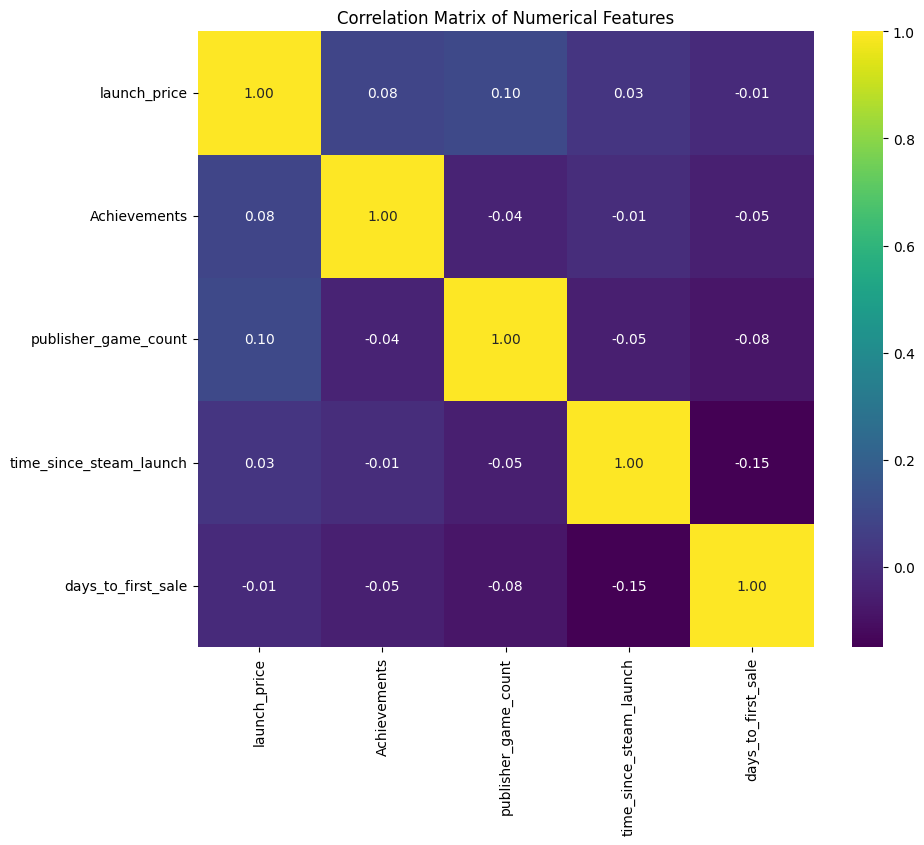

In [180]:
# coorrelation matrix of numerical features

plt.figure(figsize=(10, 8))
corr = df_merged[num_cols + ['days_to_first_sale']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='viridis', square=True)
plt.title("Correlation Matrix of Numerical Features")
plt.show()


#### From the correlation matrix we can conclude that none of the features have any significant correlation with each other. This means that each feature carries unique information and is not spread across or shared with another feature.

### To understand the relationship of the categorical variables on the target variable, I will be performing the following tests,

1. #### t-test for binary categories, to see if there is a significant difference between the means of the two groups, followed by Cohen's d test to understand the how big that difference is.

2. #### One-way ANOVA test for features that have more than two categories, followed by eta squared test to understand the difference

### t-test

### Here is the Hypothesis test setup for the t-test,
1. #### H0 (Null hypothesis): There is no difference between the means of two groups
2. #### H1 (Alternative Hypothesis): There is a significant difference between the two groups

In [181]:
record = {}

def cohen_d(x1, x2):
    """
    Compute Cohen's d for independent samples.
    """
    n1, n2 = len(x1), len(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    
    # pooled std deviation
    s_pooled = np.sqrt(((n1 - 1)*s1 + (n2 - 1)*s2) / (n1 + n2 - 2))
    d = (np.mean(x1) - np.mean(x2)) / s_pooled
    return d

def run_ttest_with_effect(df, feature, target="days_to_first_sale"):
    """
    Runs Welch's t-test on a binary categorical feature
    and reports Cohen's d effect size.
    """
    groups = df[feature].dropna().unique()
    if len(groups) != 2:
        print(f"⚠️ {feature} is not binary (found {len(groups)} groups)")
        return None
    
    g1, g2 = groups
    x1 = df.loc[df[feature] == g1, target]
    x2 = df.loc[df[feature] == g2, target]

    # Welch’s t-test (safer, doesn’t assume equal variances)
    stat, pval = ttest_ind(x1, x2, equal_var=False)
    d = cohen_d(x1, x2)
    
    record[feature] = {'group1': g1, 'mean1': x1.mean(), 'n1': len(x1), 'group2': g2, 'mean2': x2.mean(), 'n2': len(x2), 't_stat': stat, 'p_value': pval, 'cohen_d': d, 'result': '✅ significant - reject H0' if pval < 0.05 else '❌ not significant - fail to reject H0'}
    # converting record to dataframe
    record_df = pd.DataFrame.from_dict(record, orient='index')
    return record_df

# Running the test on binary features
for col in ["early_access", "mature", "Windows", "Mac", "Linux", "is_series", "is_holiday_season", "is_summer_sale_window"]:
    record_df = run_ttest_with_effect(df_merged, col)

record_df

⚠️ Windows is not binary (found 1 groups)


,group1,mean1,n1,group2,mean2,n2,t_stat,p_value,cohen_d,result
early_access,0,95.700648,28241,1,128.011086,2706,-9.363584,1.457921e-20,-0.231845,✅ significant - reject H0
mature,1,77.215365,3111,0,100.907566,27836,-11.731985,2.431670e-31,-0.169862,✅ significant - reject H0
Mac,0,97.147630,26309,1,106.343898,4638,-3.909740,9.339569e-05,-0.065865,✅ significant - reject H0
Linux,0,97.249382,27091,1,107.494035,3856,-3.978632,7.033206e-05,-0.073375,✅ significant - reject H0
is_series,0,98.928317,28863,1,92.952015,2084,2.000984,4.550464e-02,0.042794,✅ significant - reject H0
is_holiday_season,0,99.154329,26599,1,94.681233,4348,1.974100,4.841697e-02,0.032030,✅ significant - reject H0
is_summer_sale_window,0,96.729231,25579,1,107.086997,5368,-5.203998,1.997557e-07,-0.074193,✅ significant - reject H0


### t-test Results – Binary Categorical Features vs. Days to First Sale

**Key Observations:**

1. **Early Access**
   - Games in **early access** take significantly **longer to go on sale** (mean ~128 days vs ~96 days).
   - Effect size (Cohen’s d = -0.23) is **small to medium**, but meaningful.
   - Likely reflects that developers keep early access titles at full price until full release.

2. **Mature**
   - Mature-rated games go on sale **faster** (mean ~101 days vs ~77 days).
   - Statistically significant with small effect size (d = -0.17).
   - Suggests publishers of mature titles discount them earlier.

3. **Platform Availability (Mac & Linux)**
   - Both show significant differences, but effect sizes are **very small** (d ~ -0.07).
   - Interpretation: cross-platform availability has only a **minor influence** on discount timing.

4. **Series Indicator**
   - Series games vs. standalone titles are statistically different, but effect size is **negligible** (d = 0.04).
   - Suggests being part of a franchise does **not strongly impact** days to first sale.

5. **Seasonality**
   - Both holiday and summer sale window indicators are statistically significant, but effect sizes are **tiny** (d ~0.03–0.07).
   - Seasonal factors matter less than publisher/developer choices, but they still show a consistent pattern.

**Conclusion:**  
- **Early access** and **mature rating** stand out as meaningful predictors among binary features.  
- **Mac/Linux support, franchise status, and seasonality** are statistically significant but practically weak (tiny effect sizes).  
- These features may still help the model in combination with others, but on their own they’re not strong predictors.

In [182]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Required age             30947 non-null  float64       
 9   Windows                  30947 non-null  int64         
 10  Mac                      30947 non-null  int64         
 11  Linux                    30947 non-null  int64         
 12  Achievements             30947 non-nu

### One-way ANOVA test

### Here is the Hypothesis test setup for ANOVA,

1. #### H0 (Null hypothesis): All group means are equal.
2. #### H1 (Alternative hypothesis): At least one group mean is different.

In [183]:
def anova_categorical_features(df, features, target="days_to_first_sale", min_groups=3, max_groups=22000):
    """
    Runs one-way ANOVA for categorical features with more than 2 groups.
    Also computes eta squared (effect size).
    Adds a 'decision' column for significance.
    """
    rows = []
    for feat in features:
        s = df[[feat, target]].dropna()
        groups = s[feat].unique()
        ngroups = len(groups)
        
        # only test features with 3–20 distinct groups
        if ngroups < min_groups or ngroups > max_groups:
            rows.append({
                "feature": feat,
                "n_groups": ngroups,
                "status": f"skipped: {ngroups} groups"
            })
            continue
        
        # collect samples
        group_samples = [s.loc[s[feat] == g, target].values for g in groups]
        
        # run ANOVA
        f_stat, p_val = f_oneway(*group_samples)
        
        # compute eta squared
        grand_mean = s[target].mean()
        ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in group_samples)
        ss_total = sum((s[target] - grand_mean)**2)
        eta_sq = ss_between / ss_total if ss_total > 0 else np.nan
        
        # interpret effect size
        if pd.isna(eta_sq):
            effect_label = "n/a"
        elif eta_sq < 0.01:
            effect_label = "small"
        elif eta_sq < 0.06:
            effect_label = "medium"
        else:
            effect_label = "large"
        
        # add decision column
        decision = "✅ Significant - Reject H₀" if p_val < 0.05 else "❌ Not significant - Fail to reject H₀"
        
        rows.append({
            "feature": feat,
            "n_groups": ngroups,
            "f_stat": round(f_stat, 3),
            "p_value": p_val,
            "eta_sq": round(eta_sq, 3) if pd.notna(eta_sq) else np.nan,
            "effect_size": effect_label,
            "decision": decision,
            "status": "ok"
        })
    
    out = pd.DataFrame(rows)
    ok_mask = out["status"].eq("ok")
    out_ok = out[ok_mask].sort_values(["p_value", "eta_sq"], ascending=[True, False])
    out_bad = out[~ok_mask]
    return pd.concat([out_ok, out_bad], ignore_index=True)

# Example run
multi_feats = ["Developers", "Publishers", "Required age", "release_year", "release_month", "release_day", "release_quarter", "release_weekday"]
anova_results = anova_categorical_features(df_merged, multi_feats, target="days_to_first_sale")
anova_results

,feature,n_groups,f_stat,p_value,eta_sq,effect_size,decision,status
0,Developers,21203,3.439,0.000000e+00,0.882,large,✅ Significant - Reject H₀,ok
1,Publishers,18656,3.766,0.000000e+00,0.851,large,✅ Significant - Reject H₀,ok
2,release_year,4,202.169,7.286729e-130,0.019,medium,✅ Significant - Reject H₀,ok
3,release_month,12,13.779,8.396451e-27,0.005,small,✅ Significant - Reject H₀,ok
4,release_quarter,4,22.387,1.790987e-14,0.002,small,✅ Significant - Reject H₀,ok
5,release_weekday,7,10.195,2.673212e-11,0.002,small,✅ Significant - Reject H₀,ok
6,release_day,31,1.799,4.647201e-03,0.002,small,✅ Significant - Reject H₀,ok
7,Required age,9,0.856,5.531362e-01,0.000,small,❌ Not significant - Fail to reject H₀,ok


### ANOVA Test Results – Categorical Features vs. Days to First Sale

**Key Observations:**

1. **Developers & Publishers**
   - Both have **very large effect sizes** (η² ~0.88 and 0.85).
   - Strongly significant predictors of *days_to_first_sale*.
   - Intuitively makes sense: well-known publishers and experienced developers behave very differently from small indie studios.

2. **Release Timing (Year, Month, Quarter, Weekday, Day)**
   - All are **statistically significant** (p < 0.05).
   - However, effect sizes are **small**, meaning timing influences exist but are weaker compared to publisher/developer.
   - Still worth keeping, as timing may interact with seasonal patterns like holidays or big sales events.

3. **Required Age**
   - Not significant (p = 0.55).
   - No evidence that age restriction meaningfully impacts *days_to_first_sale*.
   - Likely safe to **drop this feature** from modeling.

**Conclusion:**  
I will be keeping **developers, publishers, and release timing features** and,
dropping **required age** due to lack of significance.

In [184]:
# dropping the "Required age" column as it has low significance and low effect size

df_merged.drop(columns=['Required age'], inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Windows                  30947 non-null  int64         
 9   Mac                      30947 non-null  int64         
 10  Linux                    30947 non-null  int64         
 11  Achievements             30947 non-null  int64         
 12  Developers               30947 non-nu

### Outlier detection and Handling

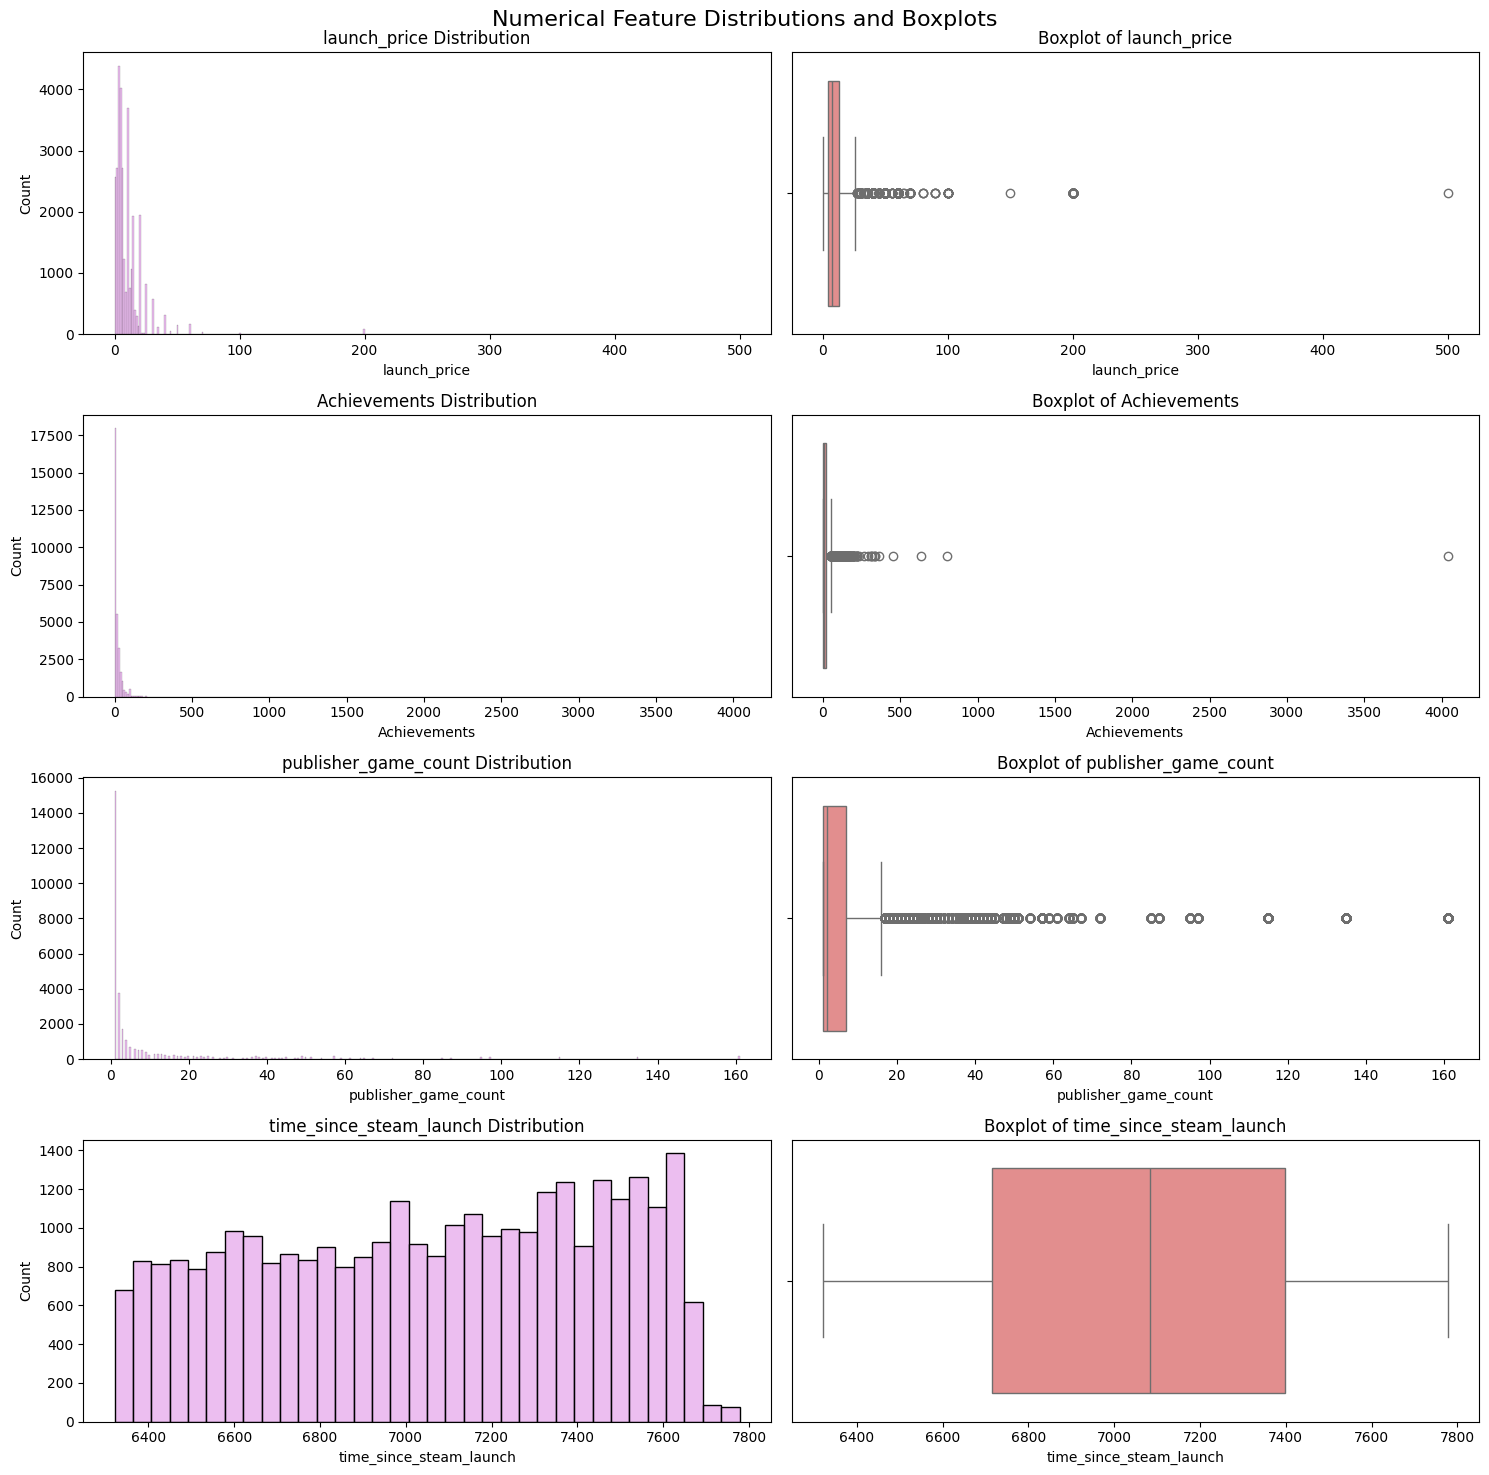

In [185]:
# plotting distribution and box plots of numerical features side by side to see the outliers

fig6, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

plt.suptitle("Numerical Feature Distributions and Boxplots", fontsize=16)

for i, col in enumerate(num_cols):
    sns.histplot(df_merged[col], ax=ax[i, 0], color='#E6A9EC')
    sns.boxplot(data=df, x=df_merged[col], ax=ax[i, 1], color='#F08080')
    ax[i, 0].set_title(f"{col} Distribution")
    ax[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()


#### Lets also calculate the percentage of outliers in the numerical features

In [186]:
# percentage of outliers in each numerical column based on 1.5*IQR rule

for col in num_cols:
    Q1 = df_merged[col].quantile(0.25)
    Q3 = df_merged[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df_merged[(df_merged[col] < lower_bound) | (df_merged[col] > upper_bound)]
    outlier_pct = (len(outliers) / len(df_merged)) * 100
    print(f"{col}: {outlier_pct:.2f}% outliers")

    

launch_price: 4.91% outliers
Achievements: 5.27% outliers
publisher_game_count: 15.63% outliers
time_since_steam_launch: 0.00% outliers


### Outlier Handling Strategy

Analyzing the numerical features and we find the following proportions of outliers:

- **launch_price**: ~4.9%  
- **achievements**: ~5.3%  
- **publisher_game_count**: ~15.6%  
- **time_since_steam_launch**: 0%  

Here’s how I am going to handle them:

1. **Launch Price**  
   I am clipping extreme launch prices to the upper bound (IQR rule) since very high values are rare and could distort training.  

2. **Achievements**  
   I am also clipping achievements at the upper bound because some games are reporting thousands of them, which looks highly unusual.  

3. **Publisher Game Count**  
   I am keeping this feature as-is. Large publishers with hundreds of games are not anomalies, they are meaningful signals of influence on discounting. Since I am mostly be using tree-based models and neural networks that can handle skew well, leaving this raw makes sense.  

4. **Time Since Steam Launch**  
   I am not making any changes here because no outliers are present.  

**Rationale**:  
I am clipping launch price and achievements to avoid distortion, but I am keeping publisher game count raw because it carries real-world meaning. This way, I can preserve valuable signals for the model.

In [187]:
# clipping "launch_price" and "achievements" at upper bound to reduce outlier impact

def clip_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series.clip(lower=lower_bound, upper=upper_bound)

df_merged['launch_price'] = clip_outliers(df_merged['launch_price'])
df_merged['Achievements'] = clip_outliers(df_merged['Achievements'])
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30947 entries, 0 to 31117
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  30947 non-null  object        
 1   appid                    30947 non-null  float64       
 2   title                    30947 non-null  object        
 3   release_date             30947 non-null  datetime64[ns]
 4   early_access             30947 non-null  int64         
 5   mature                   30947 non-null  int64         
 6   launch_price             30947 non-null  float64       
 7   days_to_first_sale       30947 non-null  int64         
 8   Windows                  30947 non-null  int64         
 9   Mac                      30947 non-null  int64         
 10  Linux                    30947 non-null  int64         
 11  Achievements             30947 non-null  int64         
 12  Developers               30947 non-nu

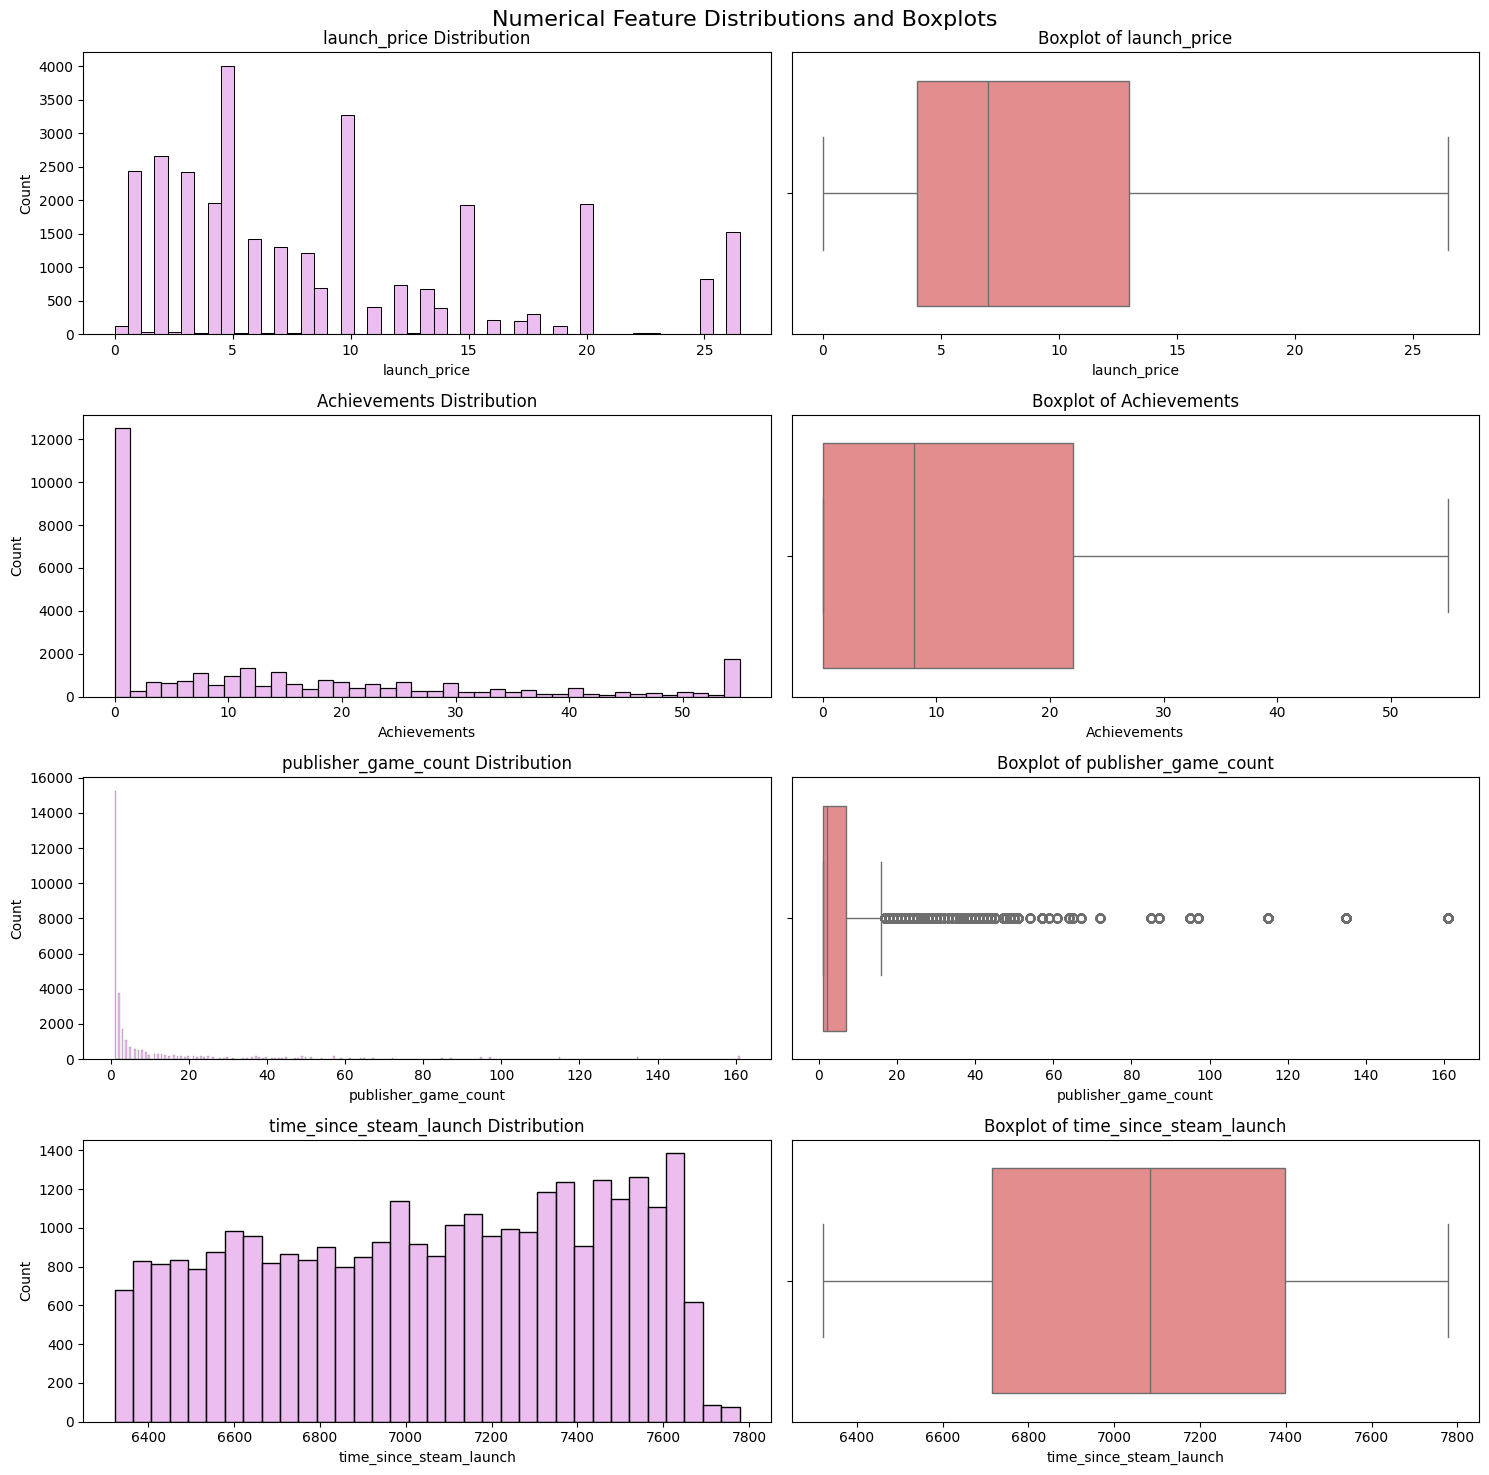

In [188]:
# lets see the distribution of all the numerical features after clipping outliers

fig6, ax = plt.subplots(nrows=4, ncols=2, figsize=(15, 15))

plt.suptitle("Numerical Feature Distributions and Boxplots", fontsize=16)

for i, col in enumerate(num_cols):
    sns.histplot(df_merged[col], ax=ax[i, 0], color='#E6A9EC')
    sns.boxplot(data=df, x=df_merged[col], ax=ax[i, 1], color='#F08080')
    ax[i, 0].set_title(f"{col} Distribution")
    ax[i, 1].set_title(f"Boxplot of {col}")

plt.tight_layout()

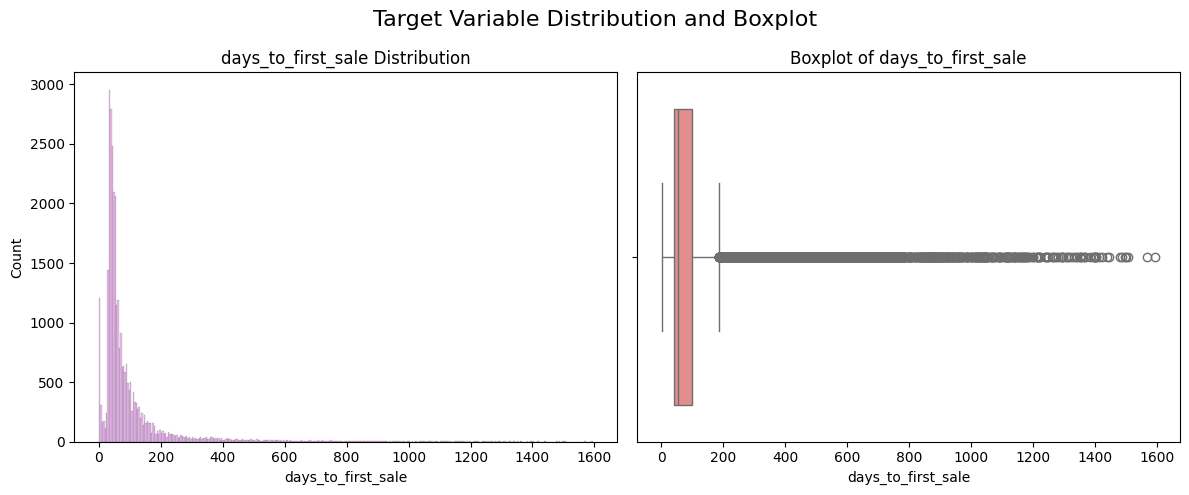

In [192]:
# distribution and boxplot of target variable "days_to_first_sale"

fig7, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.suptitle("Target Variable Distribution and Boxplot", fontsize=16)
sns.histplot(df_merged['days_to_first_sale'], ax=ax[0], color='#E6A9EC')
sns.boxplot(data=df_merged, x=df_merged['days_to_first_sale'], ax=ax[1], color='#F08080')
ax[0].set_title("days_to_first_sale Distribution")
ax[1].set_title("Boxplot of days_to_first_sale")
plt.tight_layout()


In [194]:
# calculating the number of outliers in the target variable "days_to_first_sale"

Q1 = df_merged['days_to_first_sale'].quantile(0.25)
Q3 = df_merged['days_to_first_sale'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = df_merged[(df_merged['days_to_first_sale'] < lower_bound) | (df_merged['days_to_first_sale'] > upper_bound)]
outlier_pct = (len(outliers) / len(df_merged)) * 100
print(f"days_to_first_sale: {outlier_pct:.2f}% outliers")
print(f"upper_bound: {upper_bound}, lower_bound: {lower_bound}")


days_to_first_sale: 10.29% outliers
upper_bound: 186.5, lower_bound: -49.5


In [196]:
# clipping the outliers in the target variable "days_to_first_sale" at 200

df_merged['days_to_first_sale'] = df_merged['days_to_first_sale'].clip(upper=200)

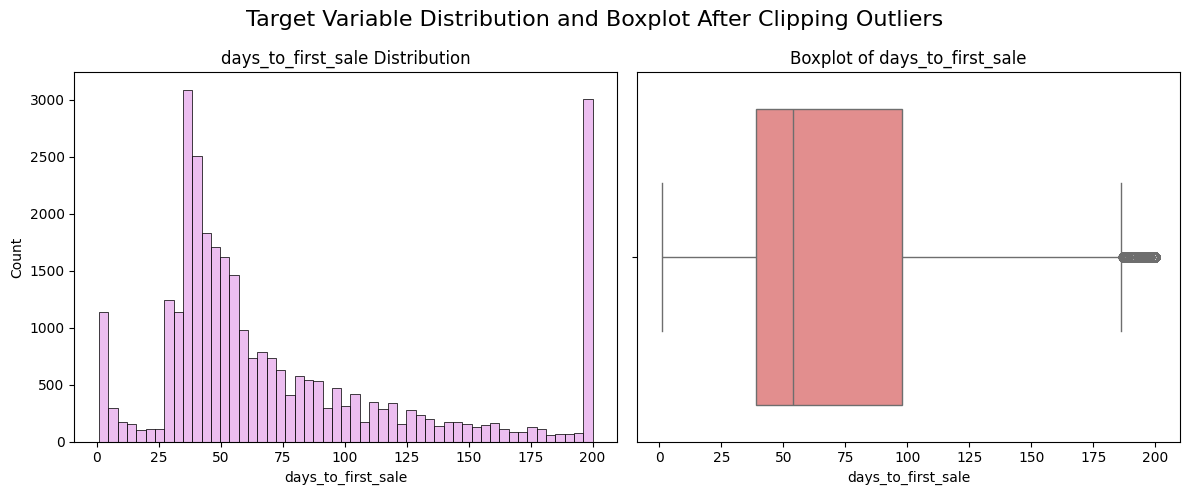

In [197]:
# distribution and boxplot of target variable "days_to_first_sale" after clipping outliers

fig7, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
plt.suptitle("Target Variable Distribution and Boxplot After Clipping Outliers", fontsize=16)
sns.histplot(df_merged['days_to_first_sale'], ax=ax[0], color='#E6A9EC')
sns.boxplot(data=df_merged, x=df_merged['days_to_first_sale'], ax=ax[1], color='#F08080')
ax[0].set_title("days_to_first_sale Distribution")
ax[1].set_title("Boxplot of days_to_first_sale")
plt.tight_layout()


In [199]:
df_merged_v2 = df_merged.copy()

In [200]:
# for testing lets try removing all the outliers from the target variable "days_to_first_sale" instead of clipping

Q1 = df_merged_v2['days_to_first_sale'].quantile(0.25)
Q3 = df_merged_v2['days_to_first_sale'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_merged_v2 = df_merged_v2[(df_merged_v2['days_to_first_sale'] >= lower_bound) & (df_merged_v2['days_to_first_sale'] <= upper_bound)]
df_merged_v2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27762 entries, 0 to 31117
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   itad_id                  27762 non-null  object        
 1   appid                    27762 non-null  float64       
 2   title                    27762 non-null  object        
 3   release_date             27762 non-null  datetime64[ns]
 4   early_access             27762 non-null  int64         
 5   mature                   27762 non-null  int64         
 6   launch_price             27762 non-null  float64       
 7   days_to_first_sale       27762 non-null  int64         
 8   Windows                  27762 non-null  int64         
 9   Mac                      27762 non-null  int64         
 10  Linux                    27762 non-null  int64         
 11  Achievements             27762 non-null  int64         
 12  Developers               27762 non-nu

In [201]:
# saving "df_merged_v2" to csv

df_merged_v2.to_csv("steam_games_target_outlier_removed.csv", index=False)

#### Saving the final data set which I will use to build and test models in another jupyter notebook.

In [198]:
# saving the final dataframe to csv

df_merged.to_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_final.csv", index=False)
df_merged.head()

,itad_id,appid,title,release_date,early_access,mature,launch_price,days_to_first_sale,Windows,Mac,...,release_year,release_month,release_day,release_quarter,release_weekday,is_holiday_season,is_summer_sale_window,time_since_steam_launch,is_series,publisher_game_count
0,018d937e-e9ba-71b7-b901-de864dd7397c,1040510.0,Princess of Zeven,2023-10-28,0,1,12.99,54,1,0,...,2023,10,28,4,5,0,0,7351,0,95
1,018d937e-e9c0-7185-a3a5-de3b8bff7956,832360.0,Hotel Magnate,2021-10-05,1,0,24.99,50,1,1,...,2021,10,5,4,1,0,0,6598,0,1
2,018d937e-e9c1-71fc-9f4a-472d6505c3cb,2361080.0,Step by Step,2023-10-06,0,0,9.99,35,1,0,...,2023,10,6,4,4,0,0,7329,0,1
3,018d937e-e9cb-728b-8309-979905bf3e82,965990.0,Destiny's Sword,2022-10-17,1,0,8.99,66,1,0,...,2022,10,17,4,0,0,0,6975,0,12
4,018d937e-e9ce-718b-9715-111f51df7457,896520.0,Stay Out of the House,2022-10-14,0,0,14.99,39,1,1,...,2022,10,14,4,4,0,0,6972,0,2


In [203]:
def create_buckets(row: list=None) -> int:
    if row <= 30:
        return 0
    elif row <= 90:
        return 1
    else:
        return 2
    
# creating a new column "sale_bucket" based on "days_to_first_sale"

df_merged['sale_bucket'] = df_merged['days_to_first_sale'].apply(create_buckets)
df_merged['sale_bucket'].value_counts()

sale_bucket
1    19511
2     8558
0     2878
Name: count, dtype: int64

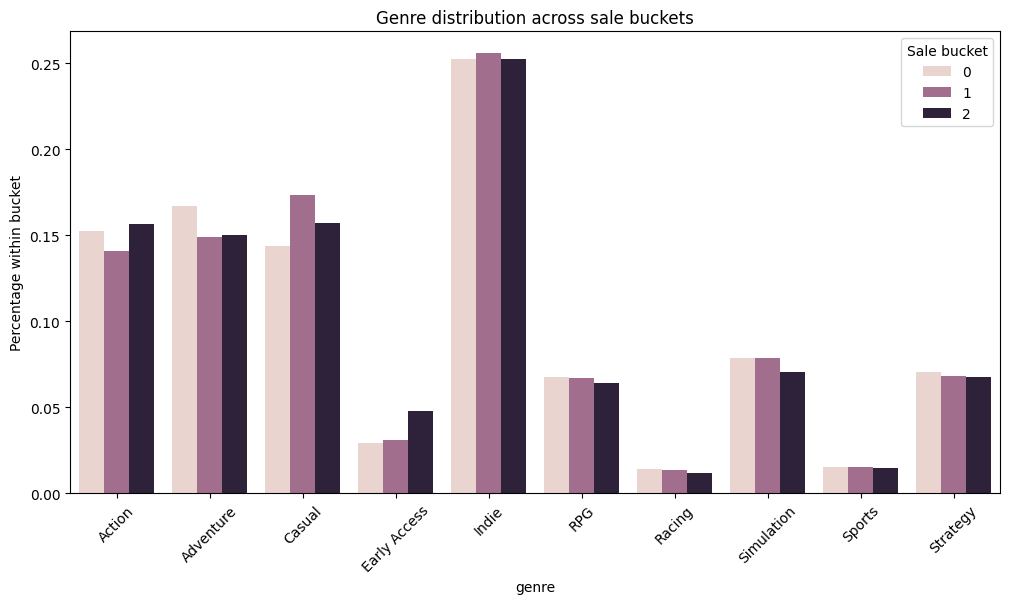

In [204]:
df_genre = df_merged.assign(genre=df_merged["Genres"].str.split(";")).explode("genre")
df_genre["genre"] = df_genre["genre"].str.strip()

# Step 2: count per bucket
genre_bucket_counts = (
    df_genre.groupby(["sale_bucket", "genre"])
            .size()
            .reset_index(name="count")
)

# Step 3: normalize within each bucket (percentage share)
genre_bucket_counts["pct"] = genre_bucket_counts.groupby("sale_bucket")["count"].transform(
    lambda x: x / x.sum()
)

# Step 4: pick top N genres overall to keep it readable
top_genres = (
    df_genre["genre"].value_counts()
    .head(10)
    .index.tolist()
)

plot_data = genre_bucket_counts[genre_bucket_counts["genre"].isin(top_genres)]

# Step 5: plot
plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x="genre",
    y="pct",
    hue="sale_bucket"
)
plt.title("Genre distribution across sale buckets")
plt.ylabel("Percentage within bucket")
plt.xticks(rotation=45)
plt.legend(title="Sale bucket")
plt.show()

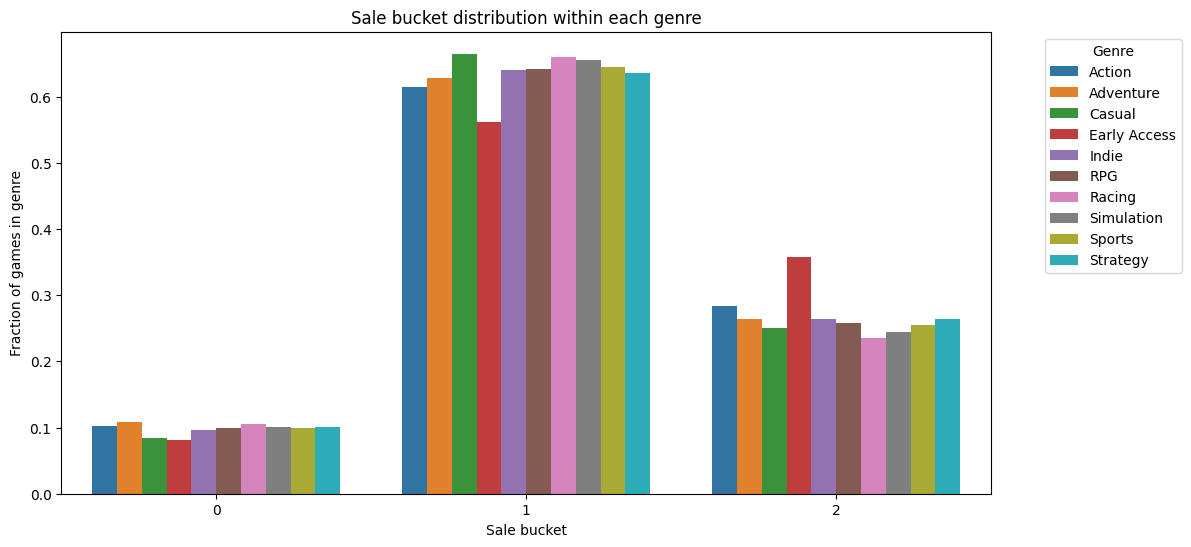

In [205]:
# Step 1: explode genres into separate rows again
df_genre = df_merged.assign(genre=df_merged["Genres"].str.split(";")).explode("genre")
df_genre["genre"] = df_genre["genre"].str.strip()

# Step 2: count bucket distribution per genre
genre_sale_dist = (
    df_genre.groupby(["genre", "sale_bucket"])
            .size()
            .reset_index(name="count")
)

# Step 3: normalize by genre (row-wise percentages)
genre_sale_dist["pct"] = genre_sale_dist.groupby("genre")["count"].transform(
    lambda x: x / x.sum()
)

# Step 4: pick top N genres to visualize
top_genres = (
    df_genre["genre"].value_counts()
    .head(10)   # change number if you want more
    .index.tolist()
)

plot_data = genre_sale_dist[genre_sale_dist["genre"].isin(top_genres)]

# Step 5: plot classes on x-axis
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.barplot(
    data=plot_data,
    x="sale_bucket",
    y="pct",
    hue="genre"
)
plt.title("Sale bucket distribution within each genre")
plt.ylabel("Fraction of games in genre")
plt.xlabel("Sale bucket")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/3698430477.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_merged, x="sale_bucket", y="launch_price", palette="Set2")


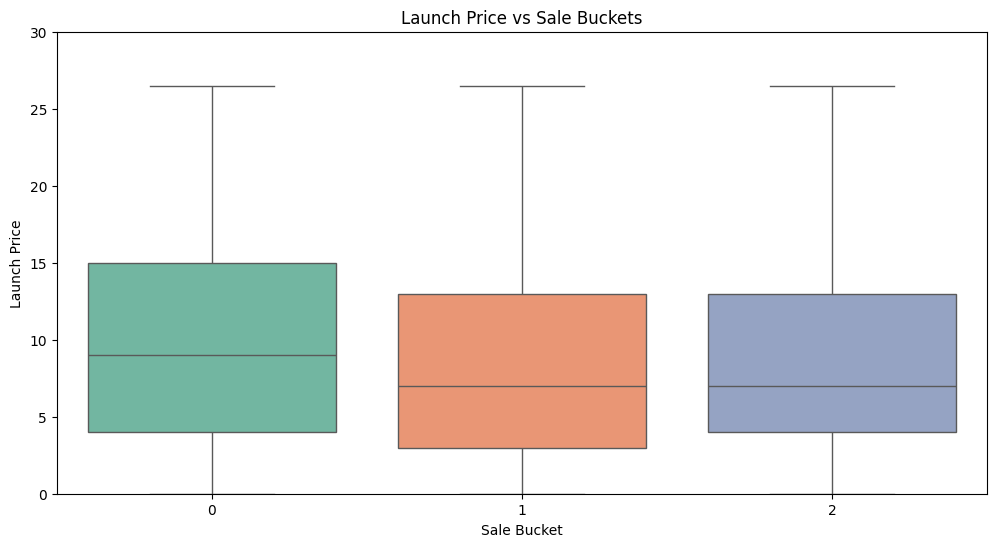

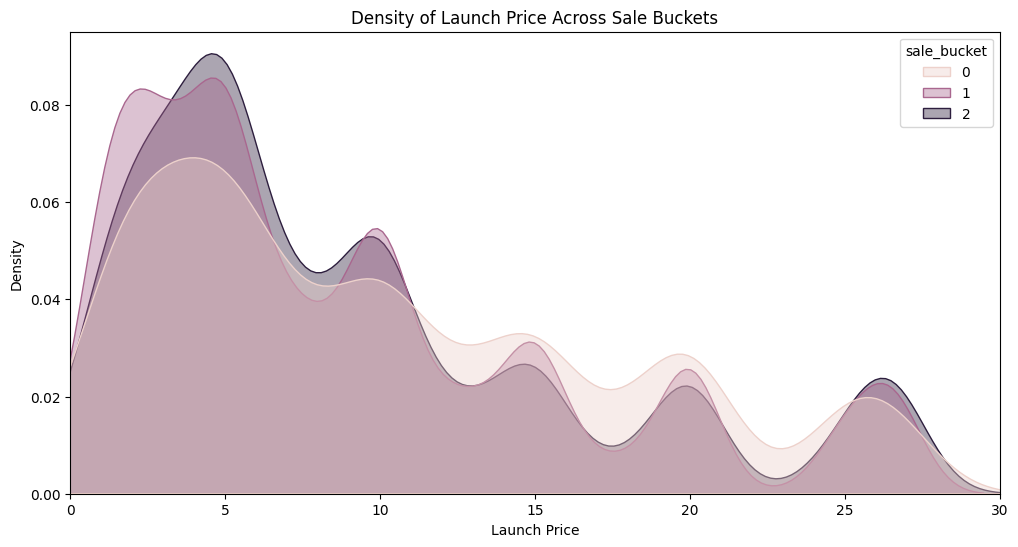

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.boxplot(data=df_merged, x="sale_bucket", y="launch_price", palette="Set2")
plt.title("Launch Price vs Sale Buckets")
plt.ylabel("Launch Price")
plt.xlabel("Sale Bucket")
plt.ylim(0, 30)  # clip to reduce extreme outlier effect
plt.show()

# Density plot for deeper view
plt.figure(figsize=(12,6))
sns.kdeplot(data=df_merged, x="launch_price", hue="sale_bucket", common_norm=False, fill=True, alpha=0.4)
plt.title("Density of Launch Price Across Sale Buckets")
plt.xlabel("Launch Price")
plt.xlim(0, 30)
plt.show()

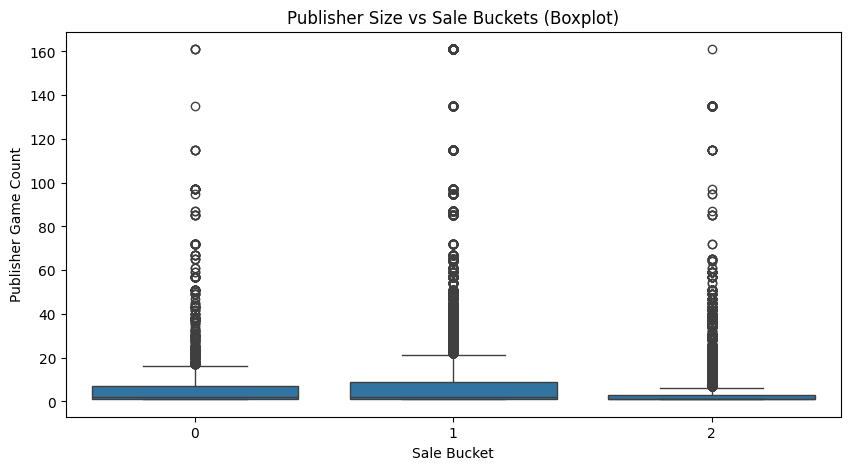

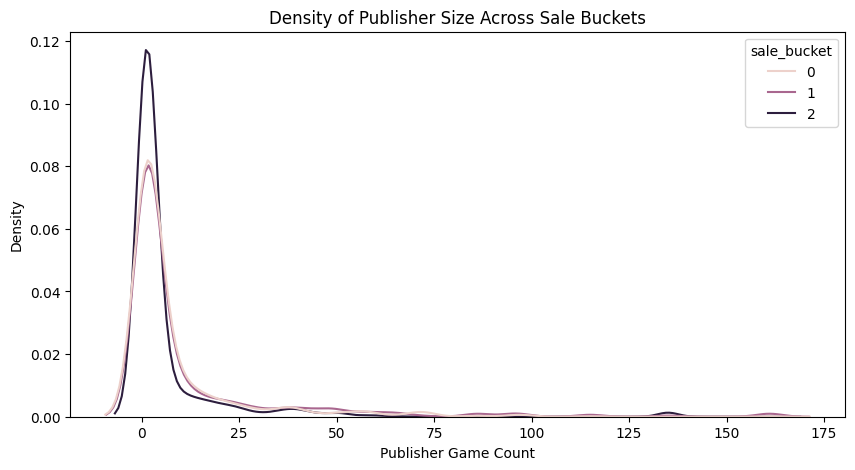

   sale_bucket  count       mean  median
0            0   2878   8.629604     2.0
1            1  19511  11.728102     2.0
2            2   8558   6.326011     1.0


In [207]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Publisher size vs sale bucket
plt.figure(figsize=(10,5))
sns.boxplot(x="sale_bucket", y="publisher_game_count", data=df_merged)
plt.title("Publisher Size vs Sale Buckets (Boxplot)")
plt.ylabel("Publisher Game Count")
plt.xlabel("Sale Bucket")
plt.show()

# KDE (distribution per bucket)
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_merged, x="publisher_game_count", hue="sale_bucket", common_norm=False)
plt.title("Density of Publisher Size Across Sale Buckets")
plt.xlabel("Publisher Game Count")
plt.show()

# Summary stats: median, mean publisher size per bucket
summary = df_merged.groupby("sale_bucket")["publisher_game_count"].agg(["count","mean","median"]).reset_index()
print(summary)

In [209]:
# joining the df_merged with df_reviews to get the review scores and counts

df_final = pd.merge(df_merged, df_reviews[['appid', 'review_score', 'review_count']], on='appid', how='left')

/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/133548797.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="sale_bucket", y="review_score", data=df_final, palette="Set2")


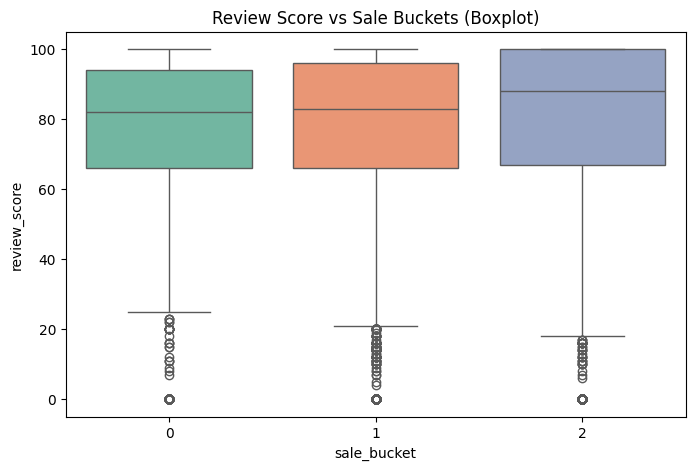

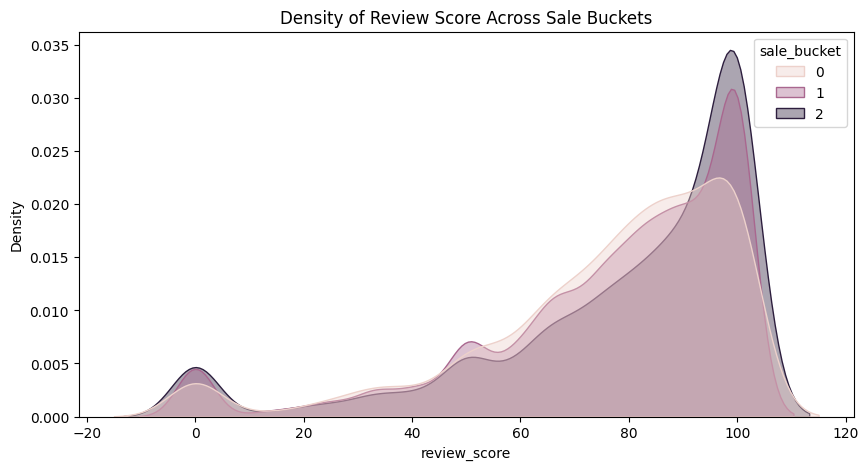

             count       mean  median
sale_bucket                          
0             2720  75.595588    82.0
1            18288  76.596894    83.0
2             7608  78.385647    88.0


In [210]:
plt.figure(figsize=(8,5))
sns.boxplot(x="sale_bucket", y="review_score", data=df_final, palette="Set2")
plt.title("Review Score vs Sale Buckets (Boxplot)")
plt.show()

# KDE plot
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_final, x="review_score", hue="sale_bucket", common_norm=False, fill=True, alpha=0.4)
plt.title("Density of Review Score Across Sale Buckets")
plt.show()

# Group stats
review_stats = (
    df_final.groupby("sale_bucket")["review_score"]
    .agg(["count", "mean", "median"])
)
print(review_stats)

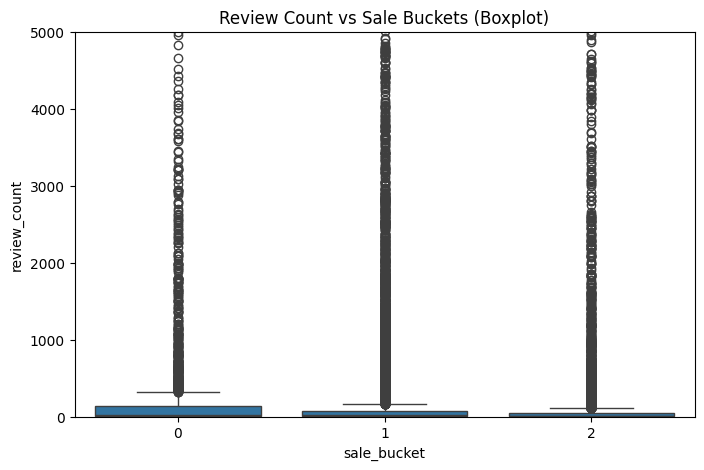

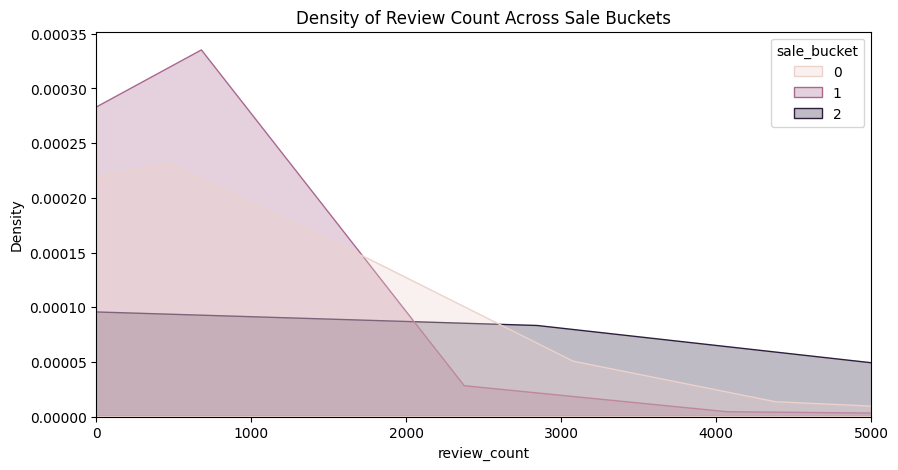

             count         mean  median       max
sale_bucket                                      
0             2720   826.002574    20.5  250164.0
1            18288   604.255796    16.0  331993.0
2             7608  1292.752234    11.0  842703.0


In [211]:
plt.figure(figsize=(8,5))
sns.boxplot(data=df_final, x="sale_bucket", y="review_count")
plt.ylim(0, 5000)  # cap y-axis for visibility (adjust if needed)
plt.title("Review Count vs Sale Buckets (Boxplot)")
plt.show()

# KDE density plot
plt.figure(figsize=(10,5))
sns.kdeplot(data=df_final, x="review_count", hue="sale_bucket", common_norm=False, fill=True, alpha=0.3)
plt.xlim(0, 5000)  # focus on bulk of distribution
plt.title("Density of Review Count Across Sale Buckets")
plt.show()

# Summary stats
review_count_summary = (
    df_final.groupby("sale_bucket")["review_count"]
    .agg(["count", "mean", "median", "max"])
)
print(review_count_summary)

   sale_bucket  count      mean    median        max
0            0   2720  7.525868  7.313887  16.816432
1            1  18288  7.240662  7.090910  17.256164
2            2   7608  6.895305  6.793466  18.208718


/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/1110813217.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


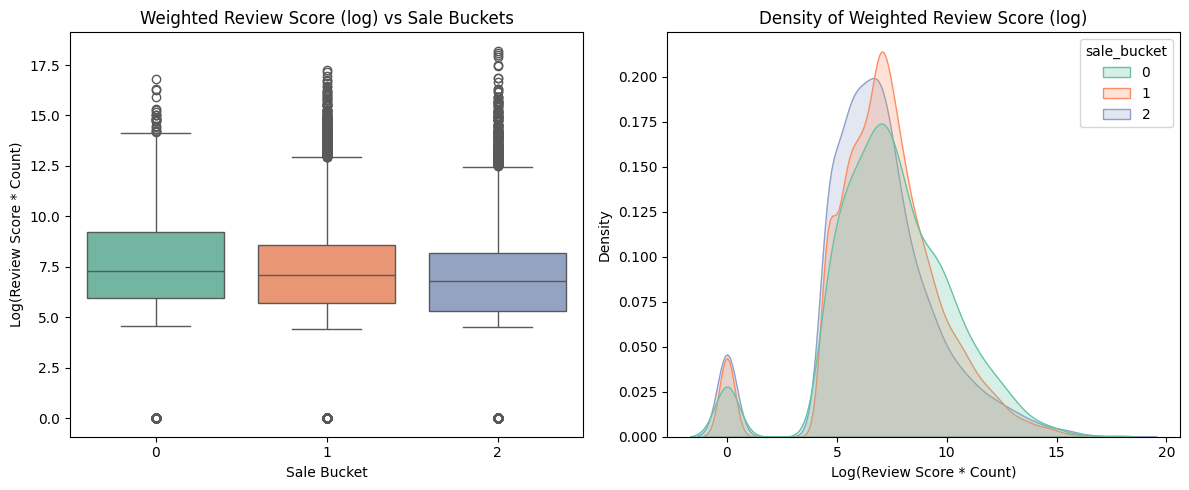

In [212]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: create weighted review score
df_final["review_score_weighted"] = (
    df_final["review_score"] * df_final["review_count"]
)

# Step 2: log transform to reduce skew
df_final["review_score_weighted_log"] = np.log1p(
    df_final["review_score_weighted"]
)

# Step 3: summary stats
summary = (
    df_final.groupby("sale_bucket")["review_score_weighted_log"]
    .agg(["count", "mean", "median", "max"])
    .reset_index()
)
print(summary)

# Step 4: visualization
plt.figure(figsize=(12,5))

# boxplot
plt.subplot(1,2,1)
sns.boxplot(
    x="sale_bucket", 
    y="review_score_weighted_log", 
    data=df_final, 
    palette="Set2"
)
plt.title("Weighted Review Score (log) vs Sale Buckets")
plt.xlabel("Sale Bucket")
plt.ylabel("Log(Review Score * Count)")

# density plot
plt.subplot(1,2,2)
sns.kdeplot(
    data=df_final, 
    x="review_score_weighted_log", 
    hue="sale_bucket", 
    fill=True, 
    common_norm=False, 
    palette="Set2"
)
plt.title("Density of Weighted Review Score (log)")
plt.xlabel("Log(Review Score * Count)")

plt.tight_layout()
plt.show()

In [213]:
df_final['release_date'] = pd.to_datetime(df_final['release_date'])
df_merged = df_merged.sort_values('release_date')

window = pd.Timedelta(days=7)
counts = []
for i, row in df_final.iterrows():
    start, end = row['release_date'] - window, row['release_date'] + window
    count = ((df_final['release_date'] >= start) & 
             (df_final['release_date'] <= end)).sum() - 1
    counts.append(count)

df_final['competition_7d'] = counts

In [216]:
import numpy as np
import pandas as pd

# ——— Inputs ———
df = df_final.copy()
df["release_date"] = pd.to_datetime(df["release_date"], utc=False)

# Sort once (needed for searchsorted)
df = df.sort_values("release_date").reset_index(drop=True)

# Convert to day-resolution integers for fast window math
d_days = df["release_date"].values.astype("datetime64[D]").astype("int64")

def competition_counts(day_ints: np.ndarray, window_days: int) -> np.ndarray:
    """
    For each date, count how many OTHER dates fall within ±window_days.
    O(n log n) via searchsorted. Excludes self automatically.
    """
    left_idx  = np.searchsorted(day_ints, day_ints - window_days, side="left")
    right_idx = np.searchsorted(day_ints, day_ints + window_days, side="right") - 1
    # inclusive window count, then exclude self -> -1
    return (right_idx - left_idx + 1) - 1

df["competition_7d"]  = competition_counts(d_days, 7)
df["competition_30d"] = competition_counts(d_days, 30)

# Put back into your original df_final order if needed
df_final = df.sort_index()

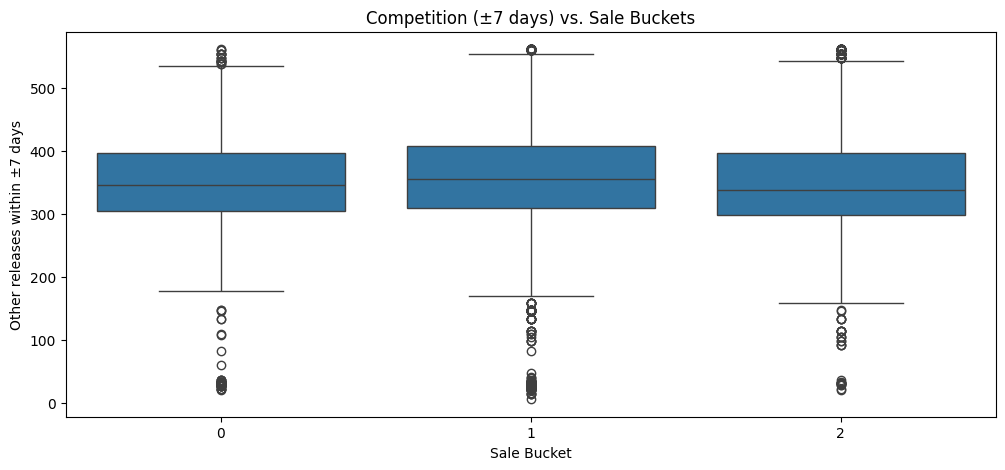

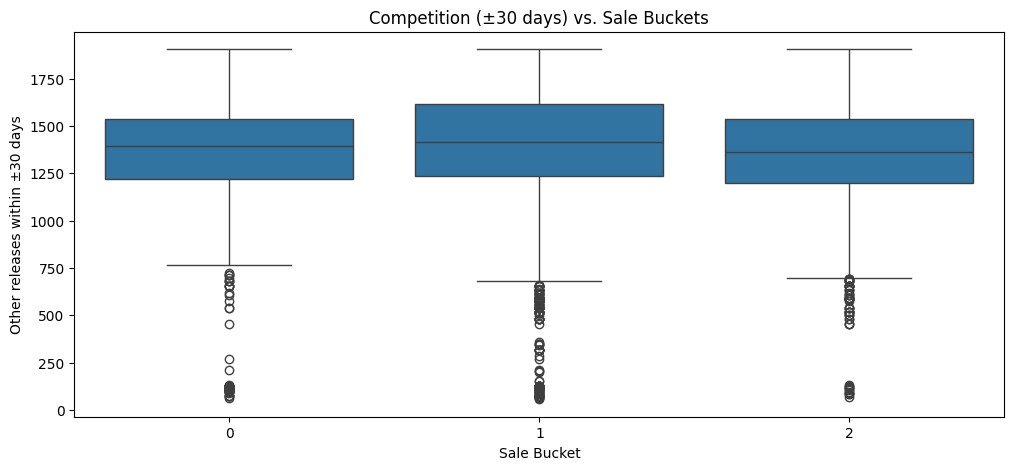

±7d competition
   sale_bucket  count        mean  median    p90  max
0            0   2878  349.347811   346.0  448.0  562
1            1  19511  360.766337   356.0  459.0  562
2            2   8558  351.642323   338.0  460.0  562

±30d competition
   sale_bucket  count         mean  median     p90   max
0            0   2878  1383.039611  1393.0  1732.0  1906
1            1  19511  1419.273692  1413.0  1748.0  1906
2            2   8558  1387.005726  1363.0  1762.0  1906


In [217]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplots
plt.figure(figsize=(12,5))
sns.boxplot(data=df_final, x="sale_bucket", y="competition_7d")
plt.title("Competition (±7 days) vs. Sale Buckets")
plt.ylabel("Other releases within ±7 days")
plt.xlabel("Sale Bucket")
plt.show()

plt.figure(figsize=(12,5))
sns.boxplot(data=df_final, x="sale_bucket", y="competition_30d")
plt.title("Competition (±30 days) vs. Sale Buckets")
plt.ylabel("Other releases within ±30 days")
plt.xlabel("Sale Bucket")
plt.show()

# Summary stats
def summarize(col):
    return (
        df_final.groupby("sale_bucket")[col]
        .agg(count="count", mean="mean", median="median",
             p90=lambda s: np.percentile(s, 90), max="max")
        .reset_index()
    )

print("±7d competition")
print(summarize("competition_7d"))
print("\n±30d competition")
print(summarize("competition_30d"))

In [219]:
df_rawg = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/rawg_platforms_dump.csv")
df_rawg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 30947 non-null  object 
 1   appid                 30947 non-null  int64  
 2   steam_release_date    30947 non-null  object 
 3   match_status          30947 non-null  object 
 4   rawg_id               10220 non-null  float64
 5   rawg_slug             10220 non-null  object 
 6   rawg_name             10220 non-null  object 
 7   rawg_released         9628 non-null   object 
 8   platform_names        10220 non-null  object 
 9   platform_slugs        10220 non-null  object 
 10  platform_released_at  10220 non-null  object 
 11  store_names           10220 non-null  object 
 12  store_slugs           10220 non-null  object 
 13  steam_appid_detected  0 non-null      float64
dtypes: float64(2), int64(1), object(11)
memory usage: 3.3+ MB


In [222]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title                      30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

In [223]:
# merging df_final with df_rawg on "appid" and keeping all the columns

df_final = df_final.merge(df_rawg, on='appid', how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 46 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title_x                    30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

In [224]:
import pandas as pd
import json

def parse_list(x):
    if pd.isna(x): 
        return []
    try:
        return json.loads(x)
    except:
        return []

df_final["store_list"] = df_final["store_slugs"].apply(parse_list)
df_final["platform_list"] = df_final["platform_slugs"].apply(parse_list)

In [226]:
# ---- Step 2 (fixed) ----
# Stores
df_final["on_epic"] = df_final["store_list"].apply(lambda s: int(any("epic" in x for x in s)))
df_final["on_gog"]  = df_final["store_list"].apply(lambda s: int(any(x == "gog" or "gog" in x for x in s)))
df_final["on_itch"] = df_final["store_list"].apply(lambda s: int(any("itch" in x for x in s)))

# Consoles (platform_slugs examples: 'playstation5','xbox-series-x','nintendo-switch')
df_final["on_playstation"] = df_final["platform_list"].apply(
    lambda s: int(any(x.startswith("playstation") for x in s))
)
df_final["on_xbox"] = df_final["platform_list"].apply(
    lambda s: int(any("xbox" in x for x in s))
)
df_final["on_switch"] = df_final["platform_list"].apply(
    lambda s: int(any("nintendo-switch" in x or x in {"wii","wii-u","3ds"} for x in s))
)

# Any console
df_final["on_console"] = (
    df_final[["on_playstation", "on_xbox", "on_switch"]].sum(axis=1) > 0
).astype(int)

# Steam-only (no other stores + no consoles)
df_final["exclusive_steam"] = (
    (df_final["on_epic"]==0) &
    (df_final["on_gog"]==0) &
    (df_final["on_itch"]==0) &
    (df_final["on_console"]==0)
).astype(int)

In [227]:
store_cols = ["on_epic","on_gog","on_itch",
              "on_playstation","on_xbox","on_switch",
              "on_console","exclusive_steam"]

summary = (
    df_final.groupby("sale_bucket")[store_cols]
    .mean()
    .round(3) * 100
)

print(summary)

             on_epic  on_gog  on_itch  on_playstation  on_xbox  on_switch  \
sale_bucket                                                                 
0                1.0     3.0      3.2             1.4      1.6        1.8   
1                0.5     1.7      1.8             1.2      1.1        1.1   
2                0.4     1.2      2.7             1.3      1.1        0.9   

             on_console  exclusive_steam  
sale_bucket                               
0                   2.6             92.6  
1                   1.8             95.2  
2                   1.7             94.8  


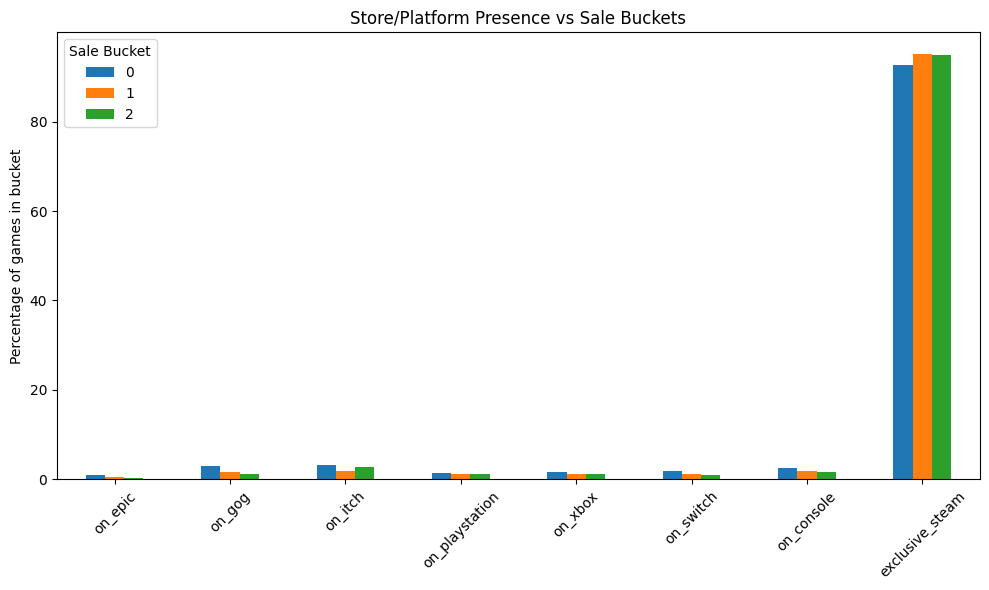

In [228]:
import matplotlib.pyplot as plt

summary.T.plot(kind="bar", figsize=(10,6))
plt.ylabel("Percentage of games in bucket")
plt.title("Store/Platform Presence vs Sale Buckets")
plt.xticks(rotation=45)
plt.legend(title="Sale Bucket")
plt.tight_layout()
plt.show()

platform_group           Multi-platform  Steam-only
sale_bucket sale_bucket                            
0           0                  7.400973   92.599027
1           1                  4.792169   95.207831
2           2                  5.211498   94.788502


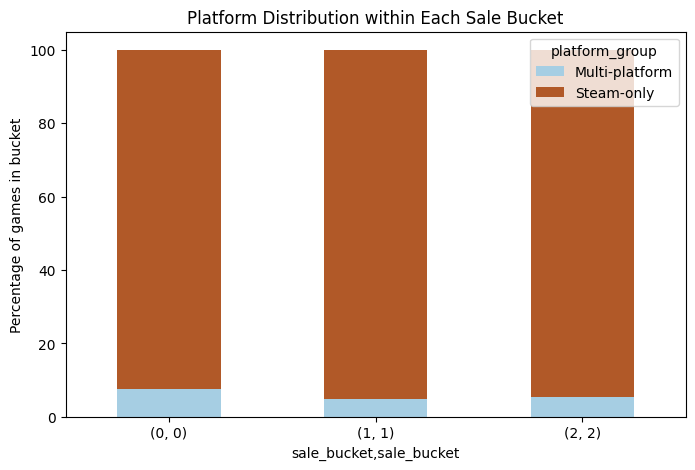

In [230]:
# Collapse into steam-only vs multi-platform
df_final["is_multi_platform"] = (
    (df_final[["on_epic", "on_gog", "on_itch",
               "on_playstation", "on_xbox", "on_switch"]].sum(axis=1) > 0).astype(int)
)

df_final["platform_group"] = df_final["is_multi_platform"].map({0: "Steam-only", 1: "Multi-platform"})

# Distribution within each sale bucket
dist = (
    df_final.groupby(["sale_bucket", "platform_group"])
    .size()
    .groupby(level=0).apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
)

print(dist)

# Plot
dist.plot(kind="bar", stacked=True, figsize=(8,5), colormap="Paired")
plt.ylabel("Percentage of games in bucket")
plt.title("Platform Distribution within Each Sale Bucket")
plt.xticks(rotation=0)
plt.show()

In [231]:
df3 = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/rawg_platforms_dump_refreshed.csv")
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   title                 30947 non-null  object 
 1   appid                 30947 non-null  int64  
 2   steam_release_date    30947 non-null  object 
 3   match_status          30947 non-null  object 
 4   rawg_id               10168 non-null  float64
 5   rawg_slug             10168 non-null  object 
 6   rawg_name             10168 non-null  object 
 7   rawg_released         9579 non-null   object 
 8   platform_names        10168 non-null  object 
 9   platform_slugs        10168 non-null  object 
 10  platform_released_at  10168 non-null  object 
 11  store_names           10168 non-null  object 
 12  store_slugs           10168 non-null  object 
 13  steam_appid_detected  0 non-null      float64
 14  is_multiplatform      30947 non-null  bool   
dtypes: bool(1), float64

In [232]:
df3['is_multiplatform'].value_counts()

is_multiplatform
False    29130
True      1817
Name: count, dtype: int64

In [233]:
# merging df_final with df3 on "appid" and keeping only the "is_multiplatform" column from df3

df_final = df_final.merge(df3[['appid', 'is_multiplatform']], on='appid', how='left')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title_x                    30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

Counts:


,Steam-only,Multi-platform
sale_bucket_lbl,,
30–90d,18442,1069
<30d,2648,230
>90d,8040,518



Percent (row-normalized):


,Steam-only,Multi-platform
sale_bucket_lbl,,
30–90d,94.52,5.48
<30d,92.01,7.99
>90d,93.95,6.05


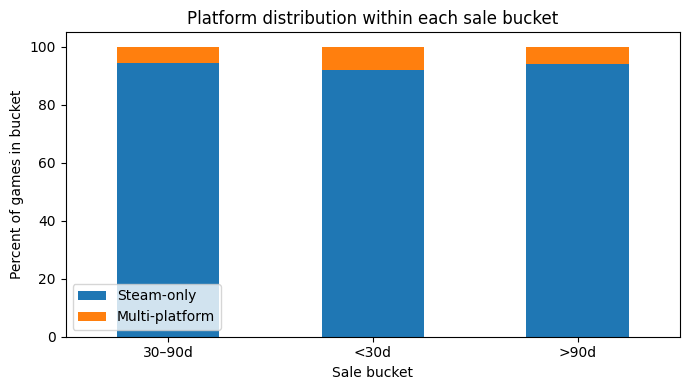

In [234]:
import pandas as pd
import matplotlib.pyplot as plt

# Optional: nicer bucket labels
bucket_labels = {0: "<30d", 1: "30–90d", 2: ">90d"}
df_plot = df_final.copy()
df_plot["sale_bucket_lbl"] = df_plot["sale_bucket"].map(bucket_labels).fillna(df_plot["sale_bucket"])

# 1) Counts by bucket × multi-platform
ct = pd.crosstab(df_plot["sale_bucket_lbl"], df_plot["is_multiplatform"])
ct.columns = ["Steam-only", "Multi-platform"]  # False, True

# 2) Percent within each bucket
pct = (ct.div(ct.sum(axis=1), axis=0) * 100).round(2)

print("Counts:")
display(ct)
print("\nPercent (row-normalized):")
display(pct)

# 3) Stacked bar plot (percentages)
ax = pct.plot(kind="bar", stacked=True, figsize=(7,4))
ax.set_ylabel("Percent of games in bucket")
ax.set_xlabel("Sale bucket")
ax.set_title("Platform distribution within each sale bucket")
ax.legend(title="")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [239]:
df_final['on_switch'].value_counts()

on_switch
0    30615
1      332
Name: count, dtype: int64

In [240]:
# creating a new column "is_multi_store_pc" which is 1 if the game is available on Epic, GOG, or Itch and is not exclusive to Steam, else 0

df_final["is_multi_store_pc"] = (
    (df_final["on_epic"] | df_final["on_gog"] | df_final["on_itch"]) &
    (~df_final["exclusive_steam"].astype(bool))
).astype(int)

In [241]:
# creating a new column "is_cross_platform" which is 1 if the game is available on any console (PlayStation, Xbox, Switch) or is multi-console, else 0

df_final["is_cross_platform"] = (
    df_final["on_playstation"] | df_final["on_xbox"] | df_final["on_switch"] | df_final["on_console"]
).astype(int)

In [242]:
# final "is_multiplatform_refined" column which is 1 if the game is either multi-store PC or cross-platform, else 0

df_final["is_multiplatform_refined"] = (
    df_final["is_multi_store_pc"] | df_final["is_cross_platform"]
).astype(int)

In [243]:
# final platform group column with 4 classes: "Steam-only", "Multi-store PC", "Cross-platform (Console)", "Unclassified"

def classify_platform(row):
    if row["is_cross_platform"]:
        return "Cross-platform (Console)"
    elif row["is_multi_store_pc"]:
        return "Multi-store PC"
    elif row["exclusive_steam"]:
        return "Steam-only"
    else:
        return "Unclassified"

df_final["platform_group_refined"] = df_final.apply(classify_platform, axis=1)

     platform_group_refined  n_games  share_late_sale  share_early_sale
0  Cross-platform (Console)      577         0.878683          0.121317
1            Multi-store PC     1017         0.873156          0.126844
2                Steam-only    29353         0.928627          0.071373


/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/3614621649.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


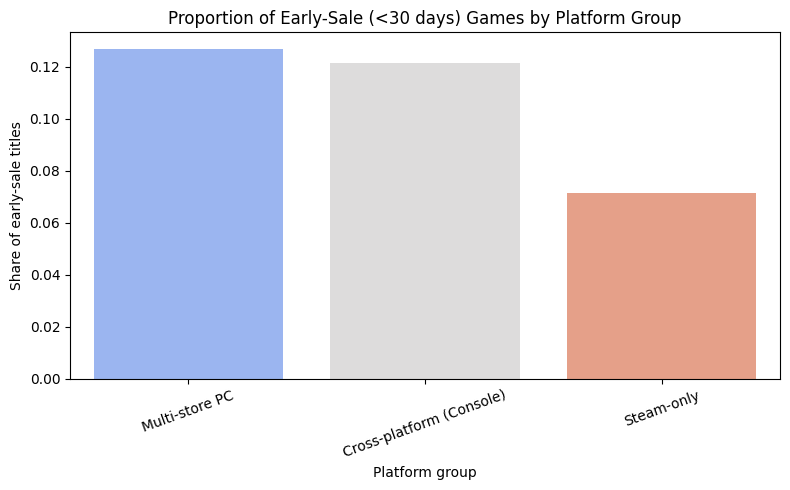

In [244]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- 1️⃣  Binary target ----
# (Assumes sale_bucket or days_to_first_sale already exists)
# 0 = <30 days, 1 = >=30 days
df_final["sale_bucket_binary"] = (df_final["days_to_first_sale"] >= 30).astype(int)

# ---- 2️⃣  Compute group-level stats ----
platform_summary = (
    df_final.groupby("platform_group_refined")["sale_bucket_binary"]
    .agg(["count", "mean"])
    .rename(columns={"count": "n_games", "mean": "share_late_sale"})
    .reset_index()
)
platform_summary["share_early_sale"] = 1 - platform_summary["share_late_sale"]

print(platform_summary)

# ---- 3️⃣  Visualize ----
plt.figure(figsize=(8, 5))
sns.barplot(
    data=platform_summary.sort_values("share_early_sale", ascending=False),
    x="platform_group_refined",
    y="share_early_sale",
    palette="coolwarm",
)
plt.title("Proportion of Early-Sale (<30 days) Games by Platform Group")
plt.ylabel("Share of early-sale titles")
plt.xlabel("Platform group")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()

In [245]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 64 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title_x                    30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

In [246]:
# feature engineering on "launch_price" column

# 1️⃣ Log transform
df_final["log_launch_price"] = np.log1p(df_final["launch_price"])

# 2️⃣ Price tier buckets (you can tune cut points)
bins = [0, 5, 15, 30, 60, np.inf]
labels = ["Ultra-low", "Low", "Mid", "High", "Premium"]
df_final["price_tier"] = pd.cut(df_final["launch_price"], bins=bins, labels=labels)

In [247]:
# feature engineering on "publisher_game_count" column

df_final["publisher_size_log"] = np.log1p(df_final["publisher_game_count"])
df_final["publisher_size_bin"] = pd.cut(
    df_final["publisher_game_count"],
    bins=[0, 5, 15, 50, np.inf],
    labels=["Small (≤5)", "Medium (6–15)", "Large (16–50)", "Major (>50)"]
)

In [248]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title_x                    30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

In [251]:
import pandas as pd
from scipy.stats import chi2_contingency

# Define target
target_col = "sale_bucket_binary"

# Select categorical columns
cat_cols = ['early_access', 'mature', 'Developers', 'Publishers', 'release_year', 'release_month', 'release_day', 'release_quarter', 
            'release_weekday', 'is_holiday_season', 'is_summer_sale_window', 'is_series', 'on_epic', 'on_gog', 'on_itch', 'on_playstation', 
            'on_xbox', 'on_switch', 'on_console', 'exclusive_steam', 'is_multi_store_pc', 'is_cross_platform', 'is_multiplatform_refined', 
            'platform_group_refined', 'price_tier', 'publisher_size_bin']

print(f"🧩 Testing {len(cat_cols)} categorical columns...\n")

results = []

for col in cat_cols:
    try:
        contingency = pd.crosstab(df_final[col], df_final[target_col])
        chi2, p, dof, ex = chi2_contingency(contingency)
        results.append({"Feature": col, "Chi2": chi2, "p-value": p})
    except Exception as e:
        print(f"⚠️ Skipping {col}: {e}")

chi2_df = pd.DataFrame(results).sort_values("p-value")
chi2_df["Significant (p<0.05)"] = chi2_df["p-value"] < 0.05
chi2_df.reset_index(drop=True, inplace=True)

# Display neatly
pd.set_option("display.float_format", lambda x: f"{x:,.3e}")
print(chi2_df)

🧩 Testing 26 categorical columns...

                     Feature      Chi2   p-value  Significant (p<0.05)
0            release_weekday 2.417e+02 2.457e-49                  True
1                 Developers 2.359e+04 1.763e-29                  True
2                 price_tier 1.299e+02 6.123e-29                  True
3                 Publishers 2.052e+04 4.004e-21                  True
4   is_multiplatform_refined 6.221e+01 3.092e-15                  True
5            exclusive_steam 6.221e+01 3.092e-15                  True
6          is_multi_store_pc 6.081e+01 6.292e-15                  True
7     platform_group_refined 6.315e+01 1.940e-14                  True
8            release_quarter 6.483e+01 5.453e-14                  True
9                     on_gog 5.202e+01 5.485e-13                  True
10              release_year 5.656e+01 3.184e-12                  True
11             release_month 7.293e+01 3.380e-11                  True
12                    mature 3.772e+01 8

In [254]:
from scipy.stats import ttest_ind
import numpy as np

target_col = "sale_bucket_binary"
num_cols = [
    "log_launch_price",
    "publisher_size_log",
    "competition_7d",
    "competition_30d",
    "time_since_steam_launch",
    "release_year",
    "Achievements"
]

results = []
group0 = df_final[df_final[target_col] == 0]
group1 = df_final[df_final[target_col] == 1]

for col in num_cols:
    # remove NaNs
    x0 = group0[col].dropna()
    x1 = group1[col].dropna()
    t_stat, p_val = ttest_ind(x0, x1, equal_var=False)
    results.append({"Feature": col, "t-stat": t_stat, "p-value": p_val})

ttest_df = pd.DataFrame(results).sort_values("p-value")
ttest_df["Significant (p<0.05)"] = ttest_df["p-value"] < 0.05
ttest_df

,Feature,t-stat,p-value,Significant (p<0.05)
0,log_launch_price,1.105e+01,8.561e-28,True
6,Achievements,9.234e+00,5.245e-20,True
3,competition_30d,-6.925e+00,5.484e-12,True
2,competition_7d,-6.923e+00,5.533e-12,True
5,release_year,-6.217e+00,5.854e-10,True
4,time_since_steam_launch,-5.040e+00,4.972e-07,True
1,publisher_size_log,2.918e+00,3.550e-03,True


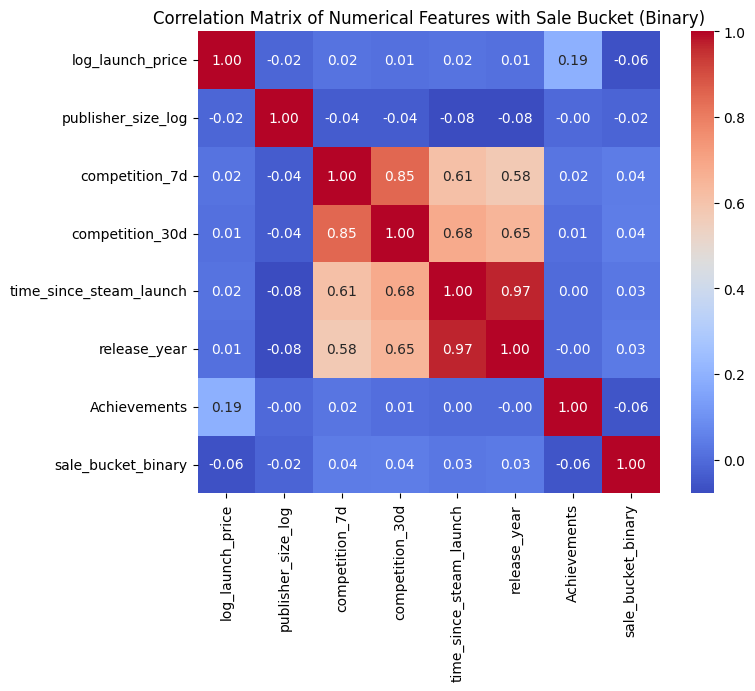

In [255]:
# correlation matrix of numerical features with respect to the binary target variable "sale_bucket_binary"

num_cols = [
    "log_launch_price",
    "publisher_size_log",
    "competition_7d",
    "competition_30d",
    "time_since_steam_launch",
    "release_year",
    "Achievements"
]

plt.figure(figsize=(8, 6))
corr = df_final[num_cols + ['sale_bucket_binary']].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix of Numerical Features with Sale Bucket (Binary)")
plt.show()


In [256]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 68 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   itad_id                    30947 non-null  object        
 1   appid                      30947 non-null  float64       
 2   title_x                    30947 non-null  object        
 3   release_date               30947 non-null  datetime64[ns]
 4   early_access               30947 non-null  int64         
 5   mature                     30947 non-null  int64         
 6   launch_price               30947 non-null  float64       
 7   days_to_first_sale         30947 non-null  int64         
 8   Windows                    30947 non-null  int64         
 9   Mac                        30947 non-null  int64         
 10  Linux                      30947 non-null  int64         
 11  Achievements               30947 non-null  int64         
 12  Deve

In [257]:
df_old = pd.read_csv("/Users/farazahmed/Documents/GitHub/steam-discount-forecast/model_data/steam_games_updated.csv")
df_old.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   itad_id                                30947 non-null  object 
 1   appid                                  30947 non-null  float64
 2   title                                  30947 non-null  object 
 3   release_date                           30947 non-null  object 
 4   early_access                           30947 non-null  int64  
 5   mature                                 30947 non-null  int64  
 6   launch_price                           30947 non-null  float64
 7   days_to_first_sale                     30947 non-null  int64  
 8   Achievements                           30947 non-null  int64  
 9   Developers                             30947 non-null  object 
 10  Publishers                             30947 non-null  object 
 11  Ca

In [258]:
# --- merge the two sources ---
df_model = (
    df_final.merge(
        df_old,
        on=["appid", "itad_id"],
        how="left",
        suffixes=("", "_old")
    )
)

# --- ensure binary target is present ---
df_model["sale_bucket_binary"] = df_model["sale_bucket_binary"].astype(int)

# --- keep relevant columns (union of key engineered + strong EDA features) ---
keep_cols = [

    # identifiers
    "appid", "itad_id", "title_x",

    # target
    "sale_bucket_binary",

    # numerical engineered
    "log_launch_price", "publisher_size_log", "competition_30d", "release_year",

    # categorical (temporal)
    "release_quarter", "release_month", "release_weekday",
    "is_holiday_season", "is_summer_sale_window",

    # categorical (content/game attributes)
    "early_access", "mature", "Achievements", "is_series",

    # publisher / developer context
    "publisher_size_bin", "Publishers", "Developers",
    "publisher_game_count", "dev_te", "pub_te",

    # platform features
    "is_multiplatform_refined", "platform_group_refined",
    "exclusive_steam", "is_multi_store_pc", "is_cross_platform",
    "is_multiplatform",

    # genre clusters (from df_old)
    "genre_cluster_sports_competitive",
    "genre_cluster_strategy_sim",
    "genre_cluster_story_action_mainstream",
    "genre_cluster_mmo",

    # steam sale and franchise dynamics
    "is_any_steam_sale_window", "is_spring_sale_window",
    "is_lunar_new_year_window", "is_autumn_sale_window",
    "is_winter_sale_window",
    "days_to_next_steam_sale", "days_since_prev_steam_sale",
    "within_7d_of_steam_sale", "franchise_count_prev",
    "franchise_avg_days_prev",

    # additional numeric signals
    "num_supported_languages", "has_prev_sale", "has_reviews"
]

# filter only those that actually exist in df_model (to avoid KeyErrors)
keep_cols = [c for c in keep_cols if c in df_model.columns]
df_model = df_model[keep_cols].copy()

# --- basic cleanup ---
df_model = df_model.drop_duplicates(subset=["appid"]).reset_index(drop=True)
print(f"Final dataset shape: {df_model.shape}")

Final dataset shape: (30947, 46)


In [259]:
import numpy as np
import pandas as pd

# --- Drop publisher_game_count (redundant with publisher_size_log) ---
if "publisher_game_count" in df_model.columns:
    df_model = df_model.drop(columns=["publisher_game_count"])

# --- Create developer_size_log (parallel to publisher_size_log) ---
if "Developers" in df_model.columns:
    dev_count = df_model["Developers"].value_counts().to_dict()
    df_model["developer_game_count"] = df_model["Developers"].map(dev_count)
    df_model["developer_size_log"] = np.log1p(df_model["developer_game_count"])

# --- Check correlations among the size metrics ---
size_corr = df_model[["publisher_size_log", "developer_size_log"]].corr()
print("Correlation between publisher and developer sizes:")
print(size_corr)

# --- Optional sanity check for redundancy ---
corr_threshold = 0.95
high_corr = size_corr.loc["publisher_size_log", "developer_size_log"]
if abs(high_corr) > corr_threshold:
    print(f"\n⚠️ Warning: publisher_size_log and developer_size_log are highly correlated ({high_corr:.2f})")
else:
    print(f"\n✅ Correlation is acceptable ({high_corr:.2f})")

# --- Clean final feature list ---
print(f"\nFinal df_model shape after cleanup: {df_model.shape}")

Correlation between publisher and developer sizes:
                    publisher_size_log  developer_size_log
publisher_size_log           1.000e+00           7.887e-01
developer_size_log           7.887e-01           1.000e+00

✅ Correlation is acceptable (0.79)

Final df_model shape after cleanup: (30947, 47)


In [260]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 47 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   appid                                  30947 non-null  float64 
 1   itad_id                                30947 non-null  object  
 2   title_x                                30947 non-null  object  
 3   sale_bucket_binary                     30947 non-null  int64   
 4   log_launch_price                       30947 non-null  float64 
 5   publisher_size_log                     30947 non-null  float64 
 6   competition_30d                        30947 non-null  int64   
 7   release_year                           30947 non-null  int32   
 8   release_quarter                        30947 non-null  int32   
 9   release_month                          30947 non-null  int32   
 10  release_weekday                        30947 non-null  int

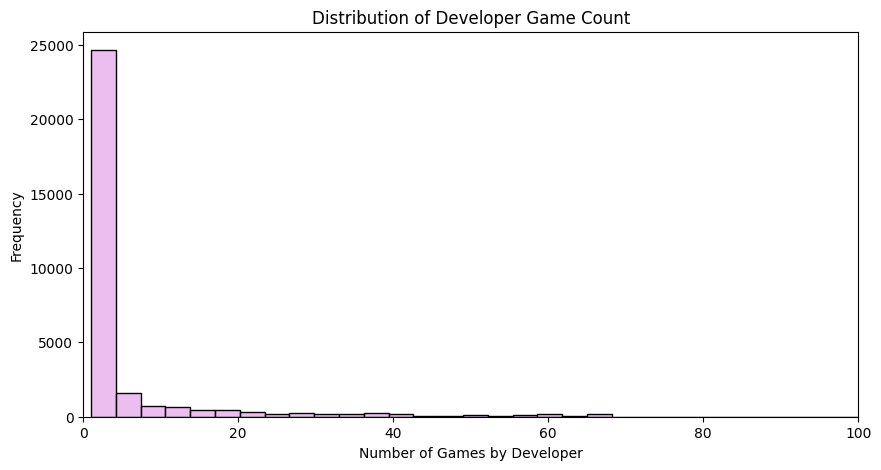

In [273]:
# distribution of "developer_game_count" column

plt.figure(figsize=(10,5))
sns.histplot(df_model['developer_game_count'], bins=50, color='#E6A9EC')
plt.title('Distribution of Developer Game Count')
plt.xlabel('Number of Games by Developer')
plt.ylabel('Frequency')
plt.xlim(0, 100)  # focus on bulk of distribution
plt.show()

In [274]:
import pandas as pd
import numpy as np

# Use your existing developer_game_count column
bins = [0, 2, 5, 15, float("inf")]
labels = ["Solo/Indie (≤2)", "Small (3–5)", "Mid (6–15)", "Large (>15)"]

df_model["developer_size_bin"] = pd.cut(
    df_model["developer_game_count"],
    bins=bins,
    labels=labels,
    include_lowest=True
)

# Optional: check the distribution
print(df_model["developer_size_bin"].value_counts(dropna=False))

developer_size_bin
Solo/Indie (≤2)    21940
Small (3–5)         3385
Large (>15)         2992
Mid (6–15)          2630
Name: count, dtype: int64


/var/folders/1f/b537t8w54jj9x40zq_pnqq4c0000gn/T/ipykernel_89105/656354745.py:17: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(combo[col]):


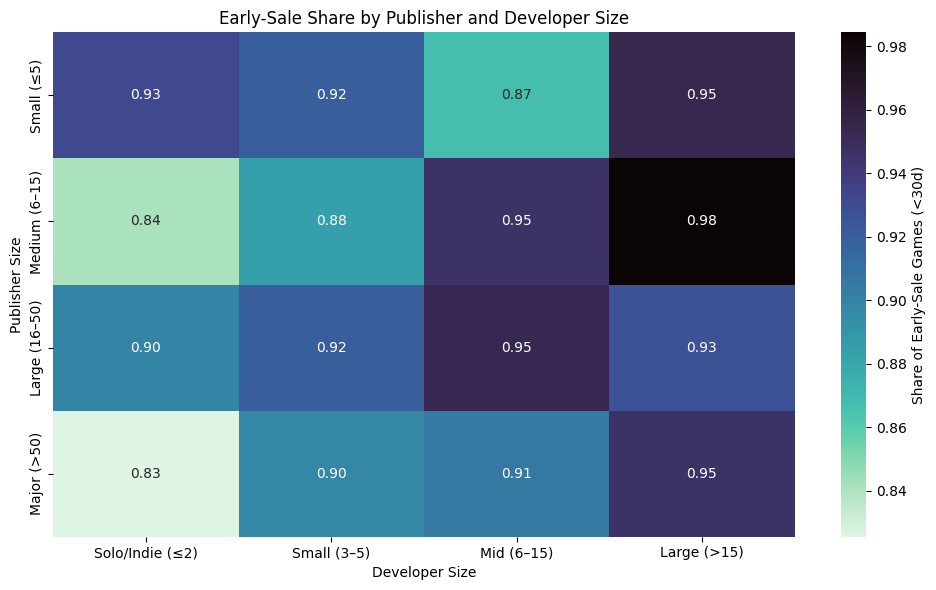

In [277]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

target = "sale_bucket_binary"  # 1 = <30d, 0 = ≥30d

# 1) Aggregate early-sale share
combo = (
    df_model.groupby(["publisher_size_bin", "developer_size_bin"], observed=True)[target]
    .mean()
    .reset_index()
    .rename(columns={target: "share_early_sale"})
)

# (Optional) ensure categorical order appears nicely
for col in ["publisher_size_bin", "developer_size_bin"]:
    if pd.api.types.is_categorical_dtype(combo[col]):
        combo[col] = combo[col].cat.as_ordered()

# 2) Pivot using keyword args (or use pivot_table)
heat = combo.pivot(index="publisher_size_bin",
                   columns="developer_size_bin",
                   values="share_early_sale")

# 3) Plot
plt.figure(figsize=(10, 6))
sns.heatmap(
    heat, annot=True, fmt=".2f",
    cmap="mako_r",
    cbar_kws={"label": "Share of Early-Sale Games (<30d)"}
)
plt.title("Early-Sale Share by Publisher and Developer Size")
plt.xlabel("Developer Size")
plt.ylabel("Publisher Size")
plt.tight_layout()
plt.show()

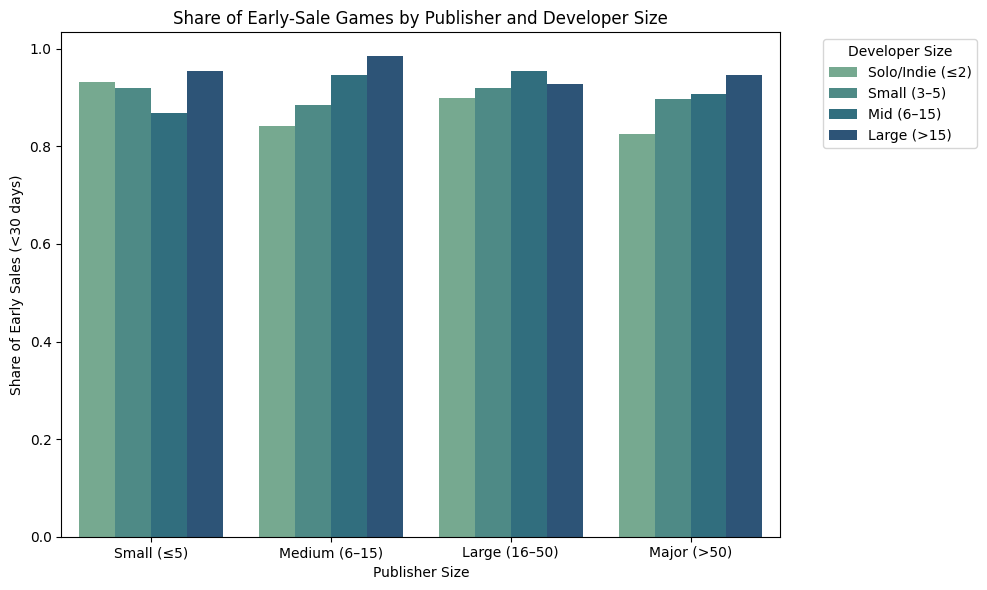

In [276]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=combo,
    x="publisher_size_bin",
    y="share_early_sale",
    hue="developer_size_bin",
    palette="crest"
)
plt.title("Share of Early-Sale Games by Publisher and Developer Size")
plt.ylabel("Share of Early Sales (<30 days)")
plt.xlabel("Publisher Size")
plt.legend(title="Developer Size", bbox_to_anchor=(1.05,1), loc="upper left")
plt.tight_layout()
plt.show()

In [278]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   appid                                  30947 non-null  float64 
 1   itad_id                                30947 non-null  object  
 2   title_x                                30947 non-null  object  
 3   sale_bucket_binary                     30947 non-null  int64   
 4   log_launch_price                       30947 non-null  float64 
 5   publisher_size_log                     30947 non-null  float64 
 6   competition_30d                        30947 non-null  int64   
 7   release_year                           30947 non-null  int32   
 8   release_quarter                        30947 non-null  int32   
 9   release_month                          30947 non-null  int32   
 10  release_weekday                        30947 non-null  int

In [280]:
import pandas as pd
from scipy.stats import chi2_contingency

TARGET = "sale_bucket_binary"  # 0/1

# <- Edit this list as you like
CAT_COLS = [
    # calendar
    "release_year", "release_quarter", "release_month", "release_weekday",
    # sales windows
    "is_any_steam_sale_window", "is_spring_sale_window", "is_lunar_new_year_window",
    "is_summer_sale_window", "is_autumn_sale_window", "is_winter_sale_window",
    # content flags
    "early_access", "mature", "Achievements", "is_series",
    # platform/store features
    "exclusive_steam", "is_multi_store_pc", "is_cross_platform",
    "is_multiplatform", "is_multiplatform_refined", "platform_group_refined",
    # publisher/dev size bins
    "publisher_size_bin", "developer_size_bin",
    # genres (your 4 clusters)
    "genre_cluster_sports_competitive", "genre_cluster_strategy_sim",
    "genre_cluster_story_action_mainstream", "genre_cluster_mmo",
    # franchise + reviews
    "has_prev_sale", "has_reviews",
    # (optionally very high-cardinality — include only if you want)
    # "Publishers", "Developers",
]

rows = []
for col in CAT_COLS:
    if col not in df_model.columns:
        rows.append({"feature": col, "status": "missing", "chi2": None, "p_value": None, "dof": None, "significant": None})
        continue

    # contingency table: levels x target(0/1)
    ct = pd.crosstab(df_model[col], df_model[TARGET])

    if ct.shape[0] < 2 or ct.shape[1] < 2:
        rows.append({"feature": col, "status": "degenerate (needs ≥2 levels & both classes)", 
                     "chi2": None, "p_value": None, "dof": None, "significant": None})
        continue

    chi2, p, dof, _ = chi2_contingency(ct.values, correction=False)
    rows.append({
        "feature": col,
        "status": "ok",
        "chi2": chi2,
        "p_value": p,
        "dof": dof,
        "significant": p < 0.05
    })

chi2_df = pd.DataFrame(rows).sort_values(["p_value", "feature"], na_position="last").reset_index(drop=True)
chi2_df

,feature,status,chi2,p_value,dof,significant
0,release_weekday,ok,2.417e+02,2.457e-49,6.000e+00,True
1,Achievements,ok,1.885e+02,1.587e-16,5.500e+01,True
2,exclusive_steam,ok,6.298e+01,2.085e-15,1.000e+00,True
3,is_multiplatform_refined,ok,6.298e+01,2.085e-15,1.000e+00,True
4,is_multi_store_pc,ok,6.167e+01,4.054e-15,1.000e+00,True
5,platform_group_refined,ok,6.315e+01,1.940e-14,2.000e+00,True
6,release_quarter,ok,6.483e+01,5.453e-14,3.000e+00,True
7,is_multiplatform,ok,5.225e+01,4.897e-13,1.000e+00,True
8,release_year,ok,5.656e+01,3.184e-12,3.000e+00,True
9,release_month,ok,7.293e+01,3.380e-11,1.100e+01,True


In [286]:
df_model['is_cross_platform'].value_counts()

is_cross_platform
0    30370
1      577
Name: count, dtype: int64

In [287]:
# 1) Start from your chi-square results DataFrame: chi2_df
#    (columns: feature, status, chi2, p_value, dof, significant)

# --- features to drop because they were NOT significant (or degenerate)
drop_not_sig = chi2_df.loc[
    (chi2_df["significant"] != True) | (chi2_df["status"] != "ok"),
    "feature"
].tolist()

# --- manual redundancies / high-cardinality you asked to remove
drop_manual = [
    "is_multiplatform",        # coarse version; keep refined + decomposed flags
    "platform_group_refined",  # group label is redundant with the binary flags
    "has_reviews",             # you said reviews don't matter for this task
    "Publishers",              # high-cardinality; we keep pub_te instead
    "Developers",              # high-cardinality; we keep dev_te instead
]

# You can add more here if you want to be aggressive about redundancy:
# e.g., if you prefer ONLY the decomposed flags, uncomment the next line to drop complements
# drop_manual += ["exclusive_steam"]  # ~ inverse of (is_multi_store_pc | is_cross_platform)

# --- build final drop list (only those that exist)
drop_cols = [c for c in set(drop_not_sig + drop_manual) if c in df_model.columns]

print("Dropping", len(drop_cols), "columns:\n", sorted(drop_cols))

# 2) Create the reduced modeling frame
df_model_reduced = df_model.drop(columns=drop_cols).copy()

print("\nShapes:")
print("Original:", df_model.shape, " -> Reduced:", df_model_reduced.shape)

# Quick peek at what remains (optional)
sorted(df_model_reduced.columns.to_list())[:30]

Dropping 13 columns:
 ['Developers', 'Publishers', 'genre_cluster_sports_competitive', 'genre_cluster_story_action_mainstream', 'has_prev_sale', 'has_reviews', 'is_any_steam_sale_window', 'is_lunar_new_year_window', 'is_multiplatform', 'is_series', 'is_spring_sale_window', 'is_winter_sale_window', 'platform_group_refined']

Shapes:
Original: (30947, 48)  -> Reduced: (30947, 35)


['Achievements',
 'appid',
 'competition_30d',
 'days_since_prev_steam_sale',
 'days_to_next_steam_sale',
 'dev_te',
 'developer_game_count',
 'developer_size_bin',
 'developer_size_log',
 'early_access',
 'exclusive_steam',
 'franchise_avg_days_prev',
 'franchise_count_prev',
 'genre_cluster_mmo',
 'genre_cluster_strategy_sim',
 'is_autumn_sale_window',
 'is_cross_platform',
 'is_holiday_season',
 'is_multi_store_pc',
 'is_multiplatform_refined',
 'is_summer_sale_window',
 'itad_id',
 'log_launch_price',
 'mature',
 'num_supported_languages',
 'pub_te',
 'publisher_size_bin',
 'publisher_size_log',
 'release_month',
 'release_quarter']

In [293]:
from scipy.stats import ttest_ind
import pandas as pd

TARGET = "sale_bucket_binary"

# List of numerical features to test (edit if needed)
NUM_COLS = [
    "log_launch_price",
    "publisher_size_log",
    "developer_size_log",
    "competition_30d",
    "release_year",
    "num_supported_languages",
    "days_to_next_steam_sale",
    "days_since_prev_steam_sale",
    "franchise_avg_days_prev",
    "franchise_count_prev"
]

rows = []
for col in NUM_COLS:
    if col not in df_model.columns:
        continue
    group0 = df_model.loc[df_model[TARGET] == 0, col].dropna()
    group1 = df_model.loc[df_model[TARGET] == 1, col].dropna()

    if len(group0) < 2 or len(group1) < 2:
        rows.append({"feature": col, "t_stat": None, "p_value": None, "significant": None})
        continue

    t_stat, p_val = ttest_ind(group0, group1, equal_var=False)  # Welch’s t-test
    rows.append({
        "feature": col,
        "t_stat": t_stat,
        "p_value": p_val,
        "significant": p_val < 0.05
    })

t_test_results = pd.DataFrame(rows).sort_values("p_value").reset_index(drop=True)
t_test_results

,feature,t_stat,p_value,significant
0,log_launch_price,1.105e+01,8.561e-28,True
1,competition_30d,-6.925e+00,5.484e-12,True
2,release_year,-6.217e+00,5.854e-10,True
3,days_to_next_steam_sale,-5.942e+00,3.170e-09,True
4,days_since_prev_steam_sale,5.340e+00,1.007e-07,True
5,developer_size_log,-3.685e+00,2.334e-04,True
6,franchise_count_prev,-3.340e+00,8.502e-04,True
7,publisher_size_log,2.918e+00,3.550e-03,True
8,franchise_avg_days_prev,-1.664e+00,9.619e-02,False
9,num_supported_languages,3.054e-01,7.601e-01,False


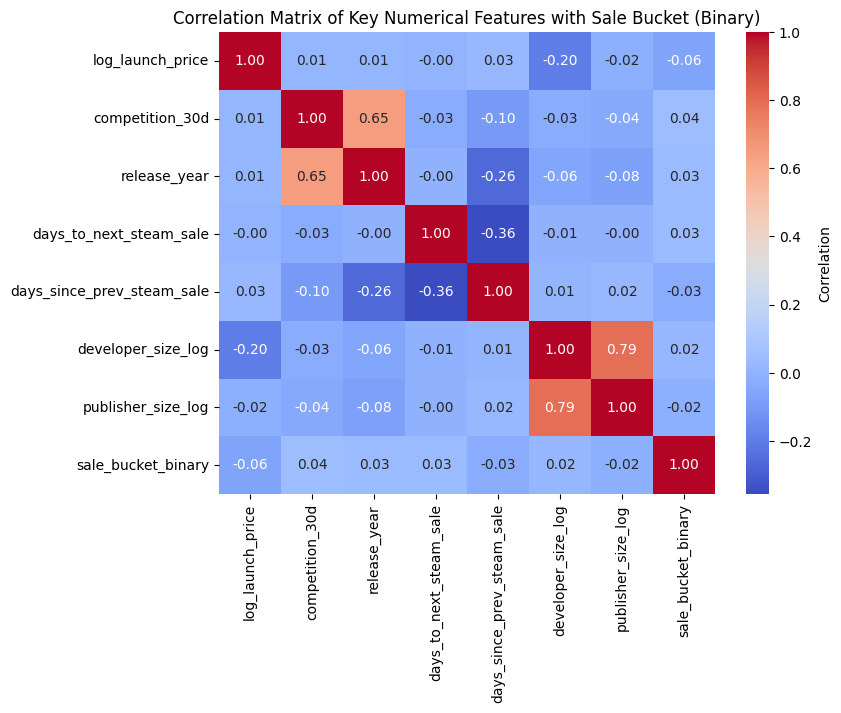


Correlation with sale_bucket_binary:

sale_bucket_binary            1.000e+00
competition_30d               4.329e-02
release_year                  3.484e-02
days_to_next_steam_sale       3.288e-02
developer_size_log            1.901e-02
publisher_size_log           -1.614e-02
days_since_prev_steam_sale   -3.160e-02
log_launch_price             -6.235e-02
Name: sale_bucket_binary, dtype: float64


In [289]:
import seaborn as sns
import matplotlib.pyplot as plt

# Final numeric features (based on t-test results)
num_features = [
    "log_launch_price",
    "competition_30d",
    "release_year",
    "days_to_next_steam_sale",
    "days_since_prev_steam_sale",
    "developer_size_log",
    "publisher_size_log",
    "sale_bucket_binary"
]

# Compute correlation matrix
corr = df_model[num_features].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    corr, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={"label": "Correlation"}
)
plt.title("Correlation Matrix of Key Numerical Features with Sale Bucket (Binary)")
plt.show()

# Optionally print correlations sorted by strength vs. target
print("\nCorrelation with sale_bucket_binary:\n")
print(corr["sale_bucket_binary"].sort_values(ascending=False))

In [290]:
# Drop features that were not significant in the t-test
drop_num_features = [
    "franchise_avg_days_prev",
    "num_supported_languages"
]

df_model_reduced = df_model.drop(columns=drop_num_features, errors="ignore")

print(f"Dropped {len(drop_num_features)} non-significant numerical features.")
print("Remaining numerical features:")
print([c for c in df_model_reduced.columns if df_model_reduced[c].dtype in ['float64', 'int64']])

Dropped 2 non-significant numerical features.
Remaining numerical features:
['appid', 'sale_bucket_binary', 'log_launch_price', 'publisher_size_log', 'competition_30d', 'is_holiday_season', 'is_summer_sale_window', 'early_access', 'mature', 'Achievements', 'is_series', 'dev_te', 'pub_te', 'is_multiplatform_refined', 'exclusive_steam', 'is_multi_store_pc', 'is_cross_platform', 'genre_cluster_sports_competitive', 'genre_cluster_strategy_sim', 'genre_cluster_story_action_mainstream', 'genre_cluster_mmo', 'is_any_steam_sale_window', 'is_spring_sale_window', 'is_lunar_new_year_window', 'is_autumn_sale_window', 'is_winter_sale_window', 'days_to_next_steam_sale', 'days_since_prev_steam_sale', 'within_7d_of_steam_sale', 'franchise_count_prev', 'has_prev_sale', 'has_reviews', 'developer_game_count', 'developer_size_log']


In [294]:
df_model_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 46 columns):
 #   Column                                 Non-Null Count  Dtype   
---  ------                                 --------------  -----   
 0   appid                                  30947 non-null  float64 
 1   itad_id                                30947 non-null  object  
 2   title_x                                30947 non-null  object  
 3   sale_bucket_binary                     30947 non-null  int64   
 4   log_launch_price                       30947 non-null  float64 
 5   publisher_size_log                     30947 non-null  float64 
 6   competition_30d                        30947 non-null  int64   
 7   release_year                           30947 non-null  int32   
 8   release_quarter                        30947 non-null  int32   
 9   release_month                          30947 non-null  int32   
 10  release_weekday                        30947 non-null  int

In [295]:
# Dropping 13 columns:
# ['Developers', 'Publishers', 'genre_cluster_sports_competitive', 'genre_cluster_story_action_mainstream', 'has_prev_sale', 'has_reviews', 'is_any_steam_sale_window', 
# 'is_lunar_new_year_window', 'is_multiplatform', 'is_series', 'is_spring_sale_window', 'is_winter_sale_window', 'platform_group_refined']

df_model_reduced.drop(columns=['title_x', 'is_series', 'Publishers', 'Developers', 'dev_te', 'pub_te', 'platform_group_refined', 'is_multiplatform',
                               'genre_cluster_sports_competitive', 'genre_cluster_story_action_mainstream', 'has_prev_sale', 'has_reviews', 'is_any_steam_sale_window',
                               'is_lunar_new_year_window', 'is_spring_sale_window', 'is_winter_sale_window'], inplace=True, errors='ignore')

df_model_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   appid                       30947 non-null  float64 
 1   itad_id                     30947 non-null  object  
 2   sale_bucket_binary          30947 non-null  int64   
 3   log_launch_price            30947 non-null  float64 
 4   publisher_size_log          30947 non-null  float64 
 5   competition_30d             30947 non-null  int64   
 6   release_year                30947 non-null  int32   
 7   release_quarter             30947 non-null  int32   
 8   release_month               30947 non-null  int32   
 9   release_weekday             30947 non-null  int32   
 10  is_holiday_season           30947 non-null  int64   
 11  is_summer_sale_window       30947 non-null  int64   
 12  early_access                30947 non-null  int64   
 13  mature          

In [296]:
df_model_reduced.drop(columns=['developer_game_count'], inplace=True, errors='ignore')
df_model_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30947 entries, 0 to 30946
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   appid                       30947 non-null  float64 
 1   itad_id                     30947 non-null  object  
 2   sale_bucket_binary          30947 non-null  int64   
 3   log_launch_price            30947 non-null  float64 
 4   publisher_size_log          30947 non-null  float64 
 5   competition_30d             30947 non-null  int64   
 6   release_year                30947 non-null  int32   
 7   release_quarter             30947 non-null  int32   
 8   release_month               30947 non-null  int32   
 9   release_weekday             30947 non-null  int32   
 10  is_holiday_season           30947 non-null  int64   
 11  is_summer_sale_window       30947 non-null  int64   
 12  early_access                30947 non-null  int64   
 13  mature          